# Transcription Factor Project - QC
**Robin Anwyl, UCSD Subramaniam Lab**

**Goal:** Analyze the hiPSC Perturb-seq dataset from the Mali lab (Nourreddine et al 2023 preprint) to investigate the effects of transcription factor knockouts (TF KDs)

**Guiding Questions:** What do TF KD effects reveal about:
* … the transcription regulatory network of hiPSCs, and TF crosstalk?
* … cell lineage?
* … how TFs influence chromatin remodeling?

***

# Import statements

Note: use terminal command " watch -n 0.1 free -h " to watch how much memory is being used

In [1]:
import sys
import os
repo_root = "/home/ranwyl/KOLF2.1J_Perturbation_Cell_Atlas/"
if repo_root not in sys.path:
    sys.path.insert(0, "/home/ranwyl/KOLF2.1J_Perturbation_Cell_Atlas/")

import psp
import gc
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'

# Convert environment.yml to requirements.txt

In [12]:
pkg_list = ["numpy", "scipy", "pandas", "matplotlib", "seaborn", "plotly", "tqdm", 
              "numba", "joblib", "scanpy", "anndata", "mudata", "muon", "harmonypy", 
              "umap-learn", "seacells", "pydeseq2", "pyranges", "sorted_nearest", "networkx", 
              "igraph", "dcor", "natsort", "statsmodels", "patsy", "toolz", "plotnine", "venn", 
              "notebook", "ipykernel", "ipywidgets", "torch", "triton", "ml-dtypes", "requests", 
              "scikit-learn", "scikit-misc", "pynndescent", "sympy"]
keep = []
with open("/home/ranwyl/KOLF2.1J_Perturbation_Cell_Atlas/environment.yml") as f:
    for i in range(7):
        next(f)
    for line in f:
        pkg = line.split("-", 1)[1].strip()
        if "==" in pkg:
            pkg = "==".join(pkg.split("==")[:2])
        else:
            pkg = "==".join(pkg.split("=", 2)[:2])
        if pkg.startswith(tuple(pkg_list)):
            keep.append(pkg)

with open("/home/ranwyl/psp_env/requirements.txt", "w") as out:
    out.write("\n".join(sorted(set(keep))) + "\n")

# Initial data quality control and cleaning

In [ ]:
import anndata as ad
import muon as mu
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def tf_project_default_qc(input_dict: dict) -> ad.AnnData:
    """
    Version of psp.qc.default_qc() that takes a .h5mu file 
    instead of 10x Genomics output files.
    """

    # Validate required inputs
    required_keys = [
        'mdata_dir', 'protospacer_calls_file', 'aggregation_csv', 
        'cell_type', 'perturbation_type', 'pre_qc_save_path',
        'final_save_path', 'gene_id_filepath', 'obs_key', 'var_key', 
        'ntc_label'
    ]
    
    for key in required_keys:
            assert key in input_dict, f"Missing required key in input_dict: {key}"
            assert isinstance(input_dict[key], str) and input_dict[key], f"{key} must be a non-empty string."

    # Validate file paths
    assert os.path.exists(input_dict['mdata_dir']), f"mdata_dir does not exist: {input_dict['mdata_dir']}"
    assert os.path.exists(input_dict['protospacer_calls_file']), f"protospacer_calls_file does not exist: {input_dict['protospacer_calls_file']}"
    assert os.path.exists(input_dict['aggregation_csv']), f"aggregation_csv does not exist: {input_dict['aggregation_csv']}"
    assert os.path.exists(input_dict['gene_id_filepath']), f"gene_id_filepath does not exist: {input_dict['gene_id_filepath']}"
    
    # Read in .h5mu file (MuData object)
    print("Reading .h5mu file...")
    mdata = mu.read_h5mu(input_dict['mdata_dir'])
    adata = mdata.mod["rna"].copy()
    
    # Assign protospacers
    print("Assigning protospacers...")
    adata = psp.qc.assign_protospacers(
        adata,
        protospacer_calls_file_path=input_dict['protospacer_calls_file'],
        NTC_Delimiter=input_dict['ntc_sgRNA_prefix']
    )
    
    # Create channel dictionary from aggregation CSV
    print("Creating channel dictionary...")
    d = pd.read_csv(input_dict['aggregation_csv'])
    channel_dict = {str(i+1): channel for i, channel in enumerate(d["sample_id"])}
    
    # Get optional treatment dictionary
    treatment_dict = input_dict.get('treatment_dict', None)
    
    # Assign metadata
    print("Assigning metadata...")
    adata = psp.qc.assign_metadata(
        adata=adata,
        cell_type=input_dict['cell_type'],
        perturbation_type=input_dict['perturbation_type'],
        channel_dict=channel_dict,
        treatment_dict=treatment_dict,
        gene_id_filepath=input_dict['gene_id_filepath'],
        obs_key=input_dict['obs_key'],
        var_key=input_dict['var_key'],
        ntc_label=input_dict['ntc_label'],
        ntc_sgRNA_prefix=input_dict['ntc_sgRNA_prefix']
    )
    
    # Convert n_gRNA_UMIs to string
    adata.obs['n_gRNA_UMIs'] = adata.obs['n_gRNA_UMIs'].astype(str)

    if 'remove_batch_duplicates' in input_dict:
        if input_dict['remove_batch_duplicates']:
            print("Removing perturbations present in multiple batches...")
            adata = psp.qc.remove_batch_duplicates(adata)
    
    # Save data after sgRNA assignment but before QC
    print(f"Saving pre-QC data to {input_dict['pre_qc_save_path']}...")
    adata.write(input_dict['pre_qc_save_path'])

    # Save data after sgRNA assignment but before QC
    # Accidentally copy pasted this part twice
    print(f"Saving pre-QC data to {input_dict['pre_qc_save_path']}...")
    adata.write(input_dict['pre_qc_save_path'])
    
    # Perform general QC
    print("Performing general QC...")
    adata = psp.qc.general_qc(adata)
    
    # Perform dead cell QC
    print("Performing dead cell QC...")
    mt_MADs = input_dict.get('mt_MADs', 5)
    count_MADs = input_dict.get('count_MADs', 5)
    ribo_MADs = input_dict.get('ribo_MADs', 5)
    
    adata = psp.qc.dead_cell_qc(
        adata,
        mt_MADs=mt_MADs,
        count_MADs=count_MADs,
        ribo_MADs=ribo_MADs
    )
    
    # Perform doublet detection sanity check
    print("Performing doublet detection sanity check...")
    psp.pl.doublet_detection_sanity_check(adata)
    
    # Save final file
    print(f"Saving final QC file to {input_dict['final_save_path']}...")
    adata.write(input_dict['final_save_path'])
    
    return adata

Reading .h5mu file...
Assigning protospacers...


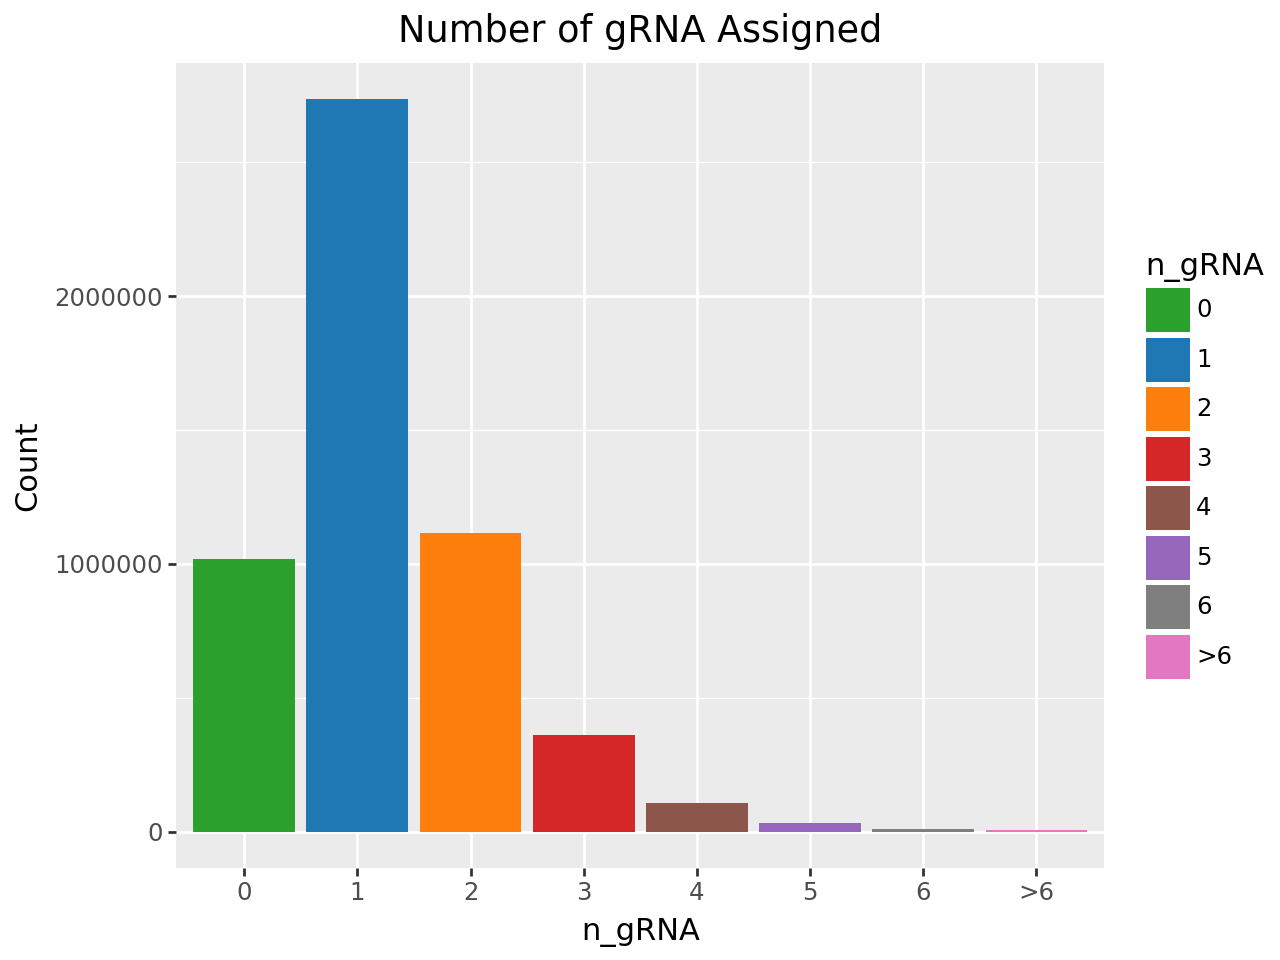

Cells without confident sgRNA calls: 18.89%
Estimated Multiplet Rate: 30.33%


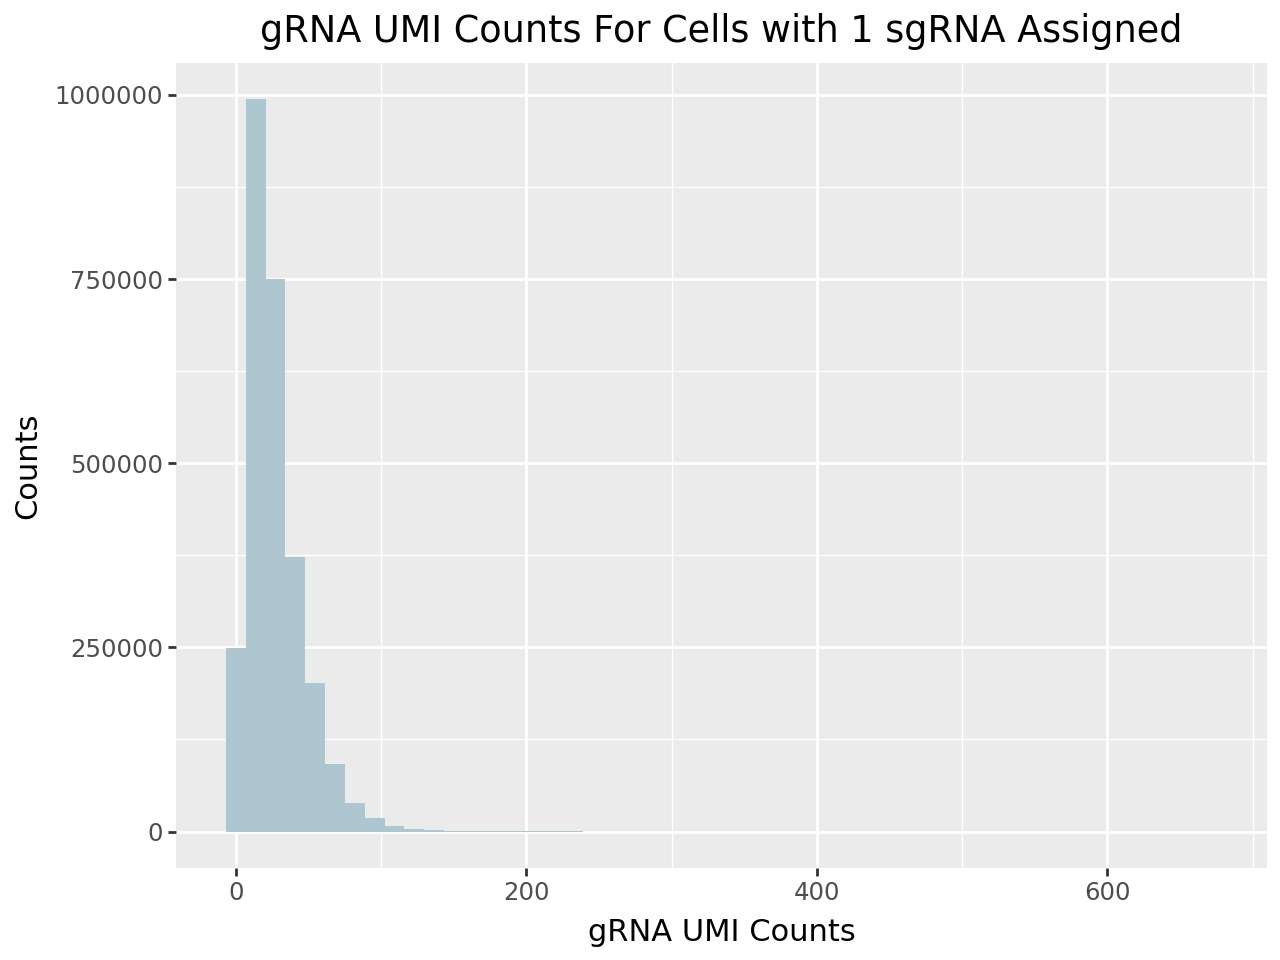

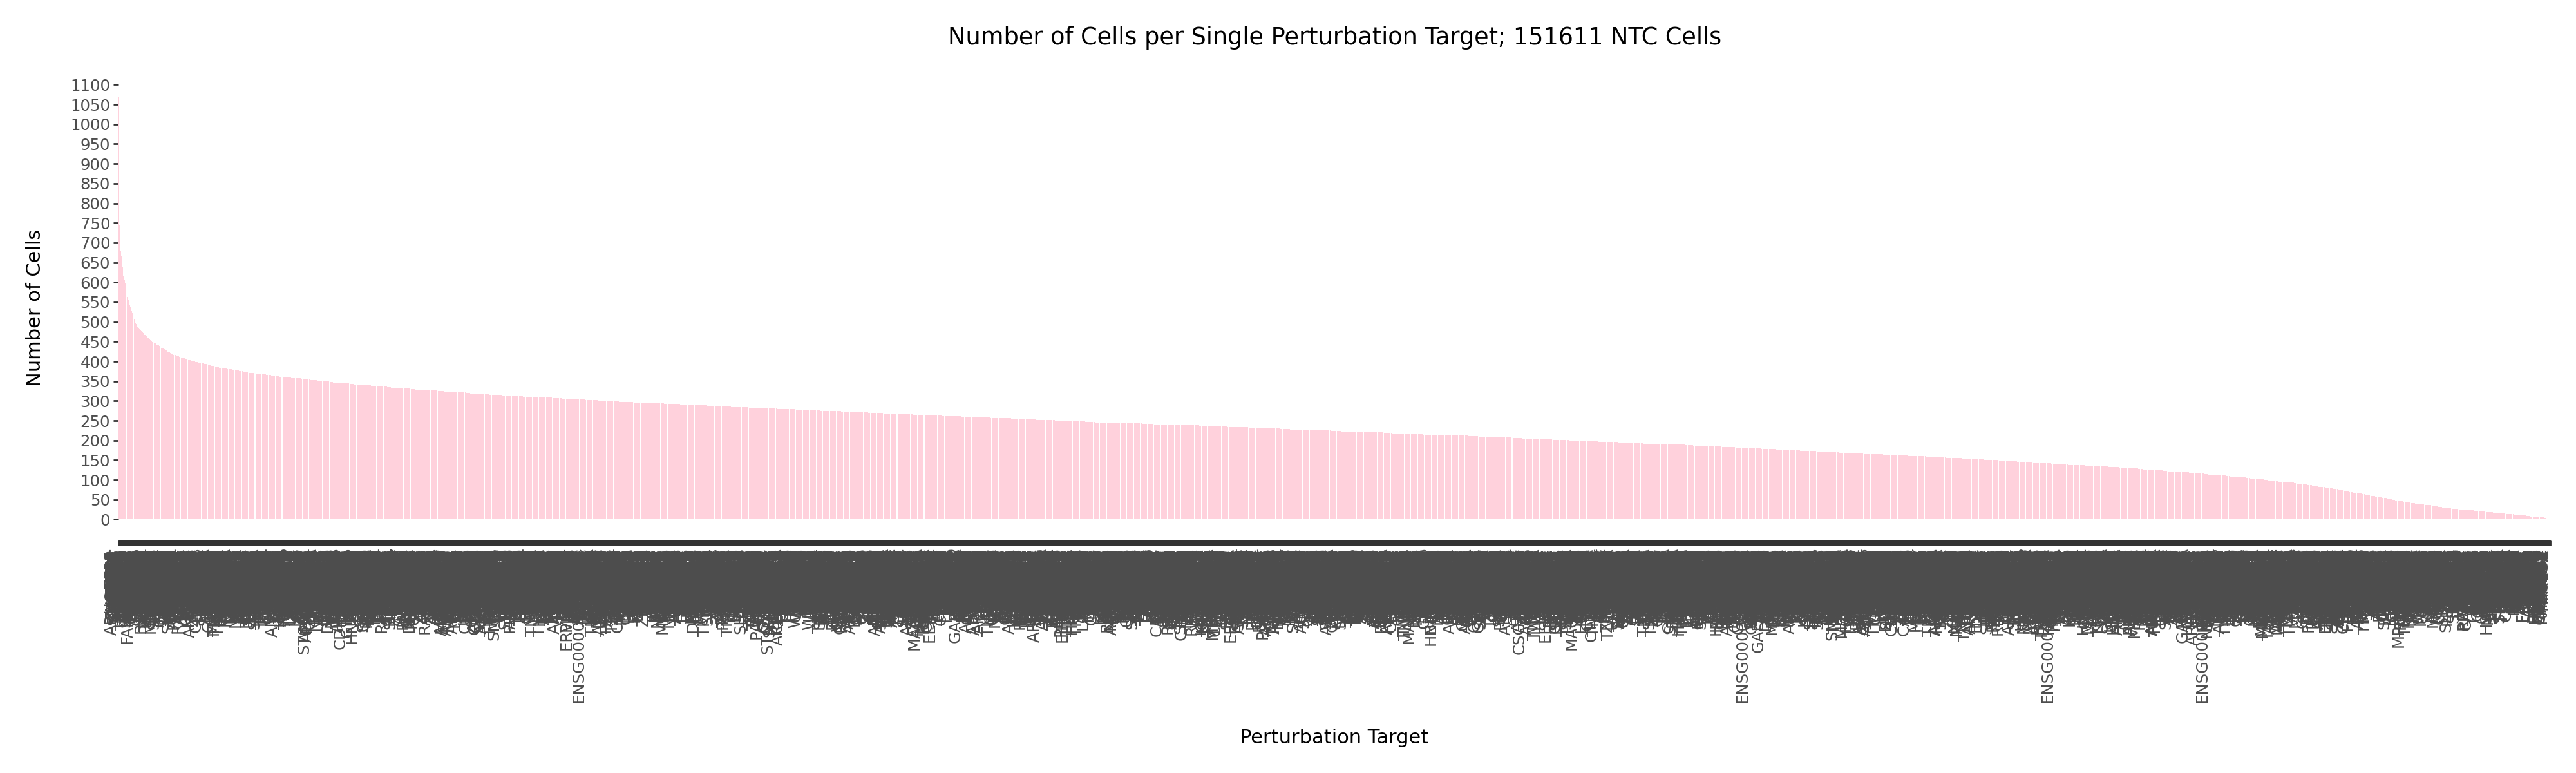

Number of perturbations with >= 50 cells with single guide assigned: 10933/11687 (93.55%)
Creating channel dictionary...
Assigning metadata...


/home/ranwyl/KOLF2.1J_Perturbation_Cell_Atlas/psp/qc/quality_control.py:353: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


Removing perturbations present in multiple batches...
Number of genes present in multiple batches: 30
(['AGAP4', 'AK6', 'AZI2', 'BORCS8', 'CCDC74A', 'CCZ1', 'CENPVL1', 'CKMT1A', 'CPNE1', 'CTAGE15', 'CTAGE4', 'ERV3-1', 'F8A1', 'FAM72B', 'HAUS3', 'KAT14', 'KIAA1586', 'KYAT3', 'NPIPA8', 'NPIPB13', 'PCDHB13', 'PITPNM1', 'PURB', 'RABL2B', 'SLX1A', 'SMN1', 'TCEAL2', 'TIMM23', 'TRAPPC2B', 'ZBED6'])
Selecting the batch with the most sgRNAs per gene
Saving pre-QC data to /home/ranwyl/data_tf_project/KOLF_Pan_Genome_Pre_QC.h5ad...
Saving pre-QC data to /home/ranwyl/data_tf_project/KOLF_Pan_Genome_Pre_QC.h5ad...
Performing general QC...


In [ ]:
mdata_dir = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Aggregate.h5mu"
protospacer_calls_file = "/home/ranwyl/data_tf_project/input_files/protospacer_calls_per_cell.csv"
aggregation_csv = "/home/ranwyl/data_tf_project/input_files/aggregation_csv.csv"
cell_type = "KRAB-ZIM3-dCas9 KOLF2.1J hiPSC"
perturbation_type = "CRISPRi"
pre_qc_save_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Pre_QC.h5ad"
final_save_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_QC_Filtered.h5ad"
gene_id_filepath = "/home/ranwyl/data_tf_project/input_files/gene_ids.txt"
obs_key = "gene_target_ensembl_id"
var_key = "gene_ids"
ntc_label = "NTC"
ntc_sgRNA_prefix = "Non-Targeting"
remove_batch_duplicates = True
count_MADs = 3 # Different from default 5

input_dict = {
    "mdata_dir": mdata_dir,
    "protospacer_calls_file": protospacer_calls_file,
    "aggregation_csv": aggregation_csv,
    "cell_type": cell_type,
    "perturbation_type": perturbation_type,
    "pre_qc_save_path": pre_qc_save_path,
    "final_save_path": final_save_path,
    "gene_id_filepath": gene_id_filepath,
    "obs_key": obs_key,
    "var_key": var_key,
    "ntc_label": ntc_label,
    "ntc_sgRNA_prefix": ntc_sgRNA_prefix,
    "remove_batch_duplicates": remove_batch_duplicates,
    "count_MADs": count_MADs
}

adata = tf_project_default_qc(input_dict)

Restarted kernel due to high RAM usage

In [3]:
import anndata as ad
import muon as mu
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def tf_project_general_qc_cell_qc(adata, input_dict) -> ad.AnnData:
    """
    QC steps
    """
    # Perform general QC
    print("Performing general QC...")
    adata = psp.qc.general_qc(adata)
    
    # Perform dead cell QC
    print("Performing dead cell QC...")
    mt_MADs = input_dict.get('mt_MADs', 5)
    count_MADs = input_dict.get('count_MADs', 5)
    ribo_MADs = input_dict.get('ribo_MADs', 5)
    
    adata = psp.qc.dead_cell_qc(
        adata,
        mt_MADs=mt_MADs,
        count_MADs=count_MADs,
        ribo_MADs=ribo_MADs
    )
    
    # Perform doublet detection sanity check
    print("Performing doublet detection sanity check...")
    psp.pl.doublet_detection_sanity_check(adata)
    
    # Save final file
    print(f"Saving final QC file to {input_dict['final_save_path']}...")
    adata.write(input_dict['final_save_path'])
    
    return adata

Performing general QC...
normalizing counts per cell
    finished (0:00:17)


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

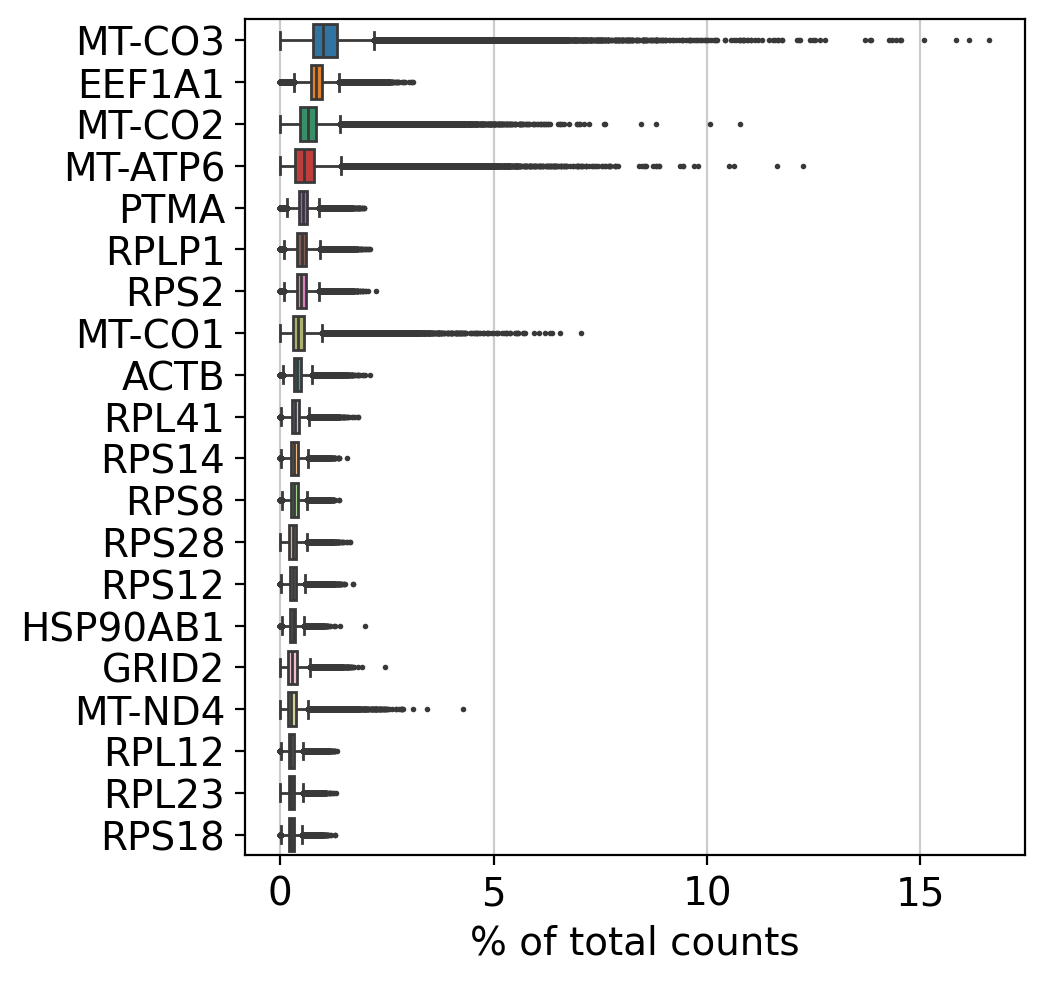

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

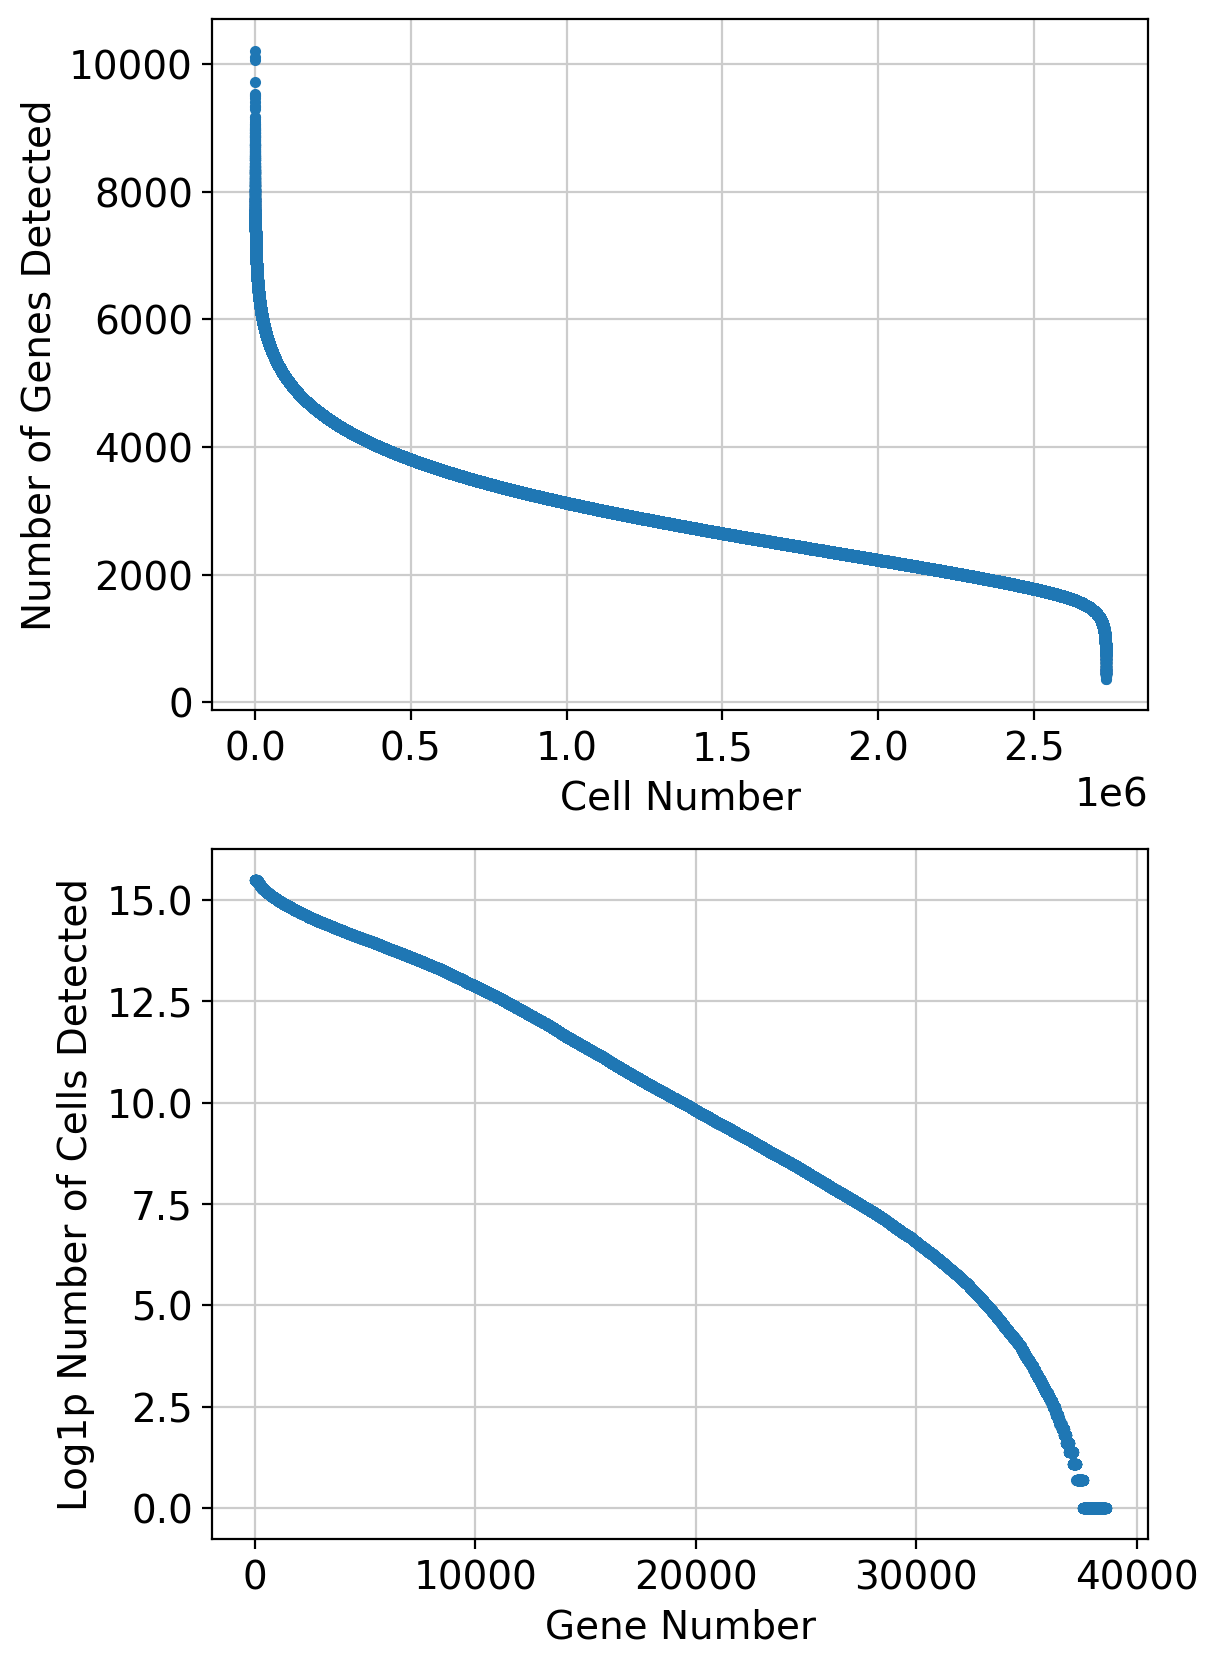

Removing 1039 genes not detected in any cells.
Performing dead cell QC...


/home/ranwyl/KOLF2.1J_Perturbation_Cell_Atlas/psp/qc/quality_control.py:437: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.


outlier
False    2498824
True      232183
Name: count, dtype: int64

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

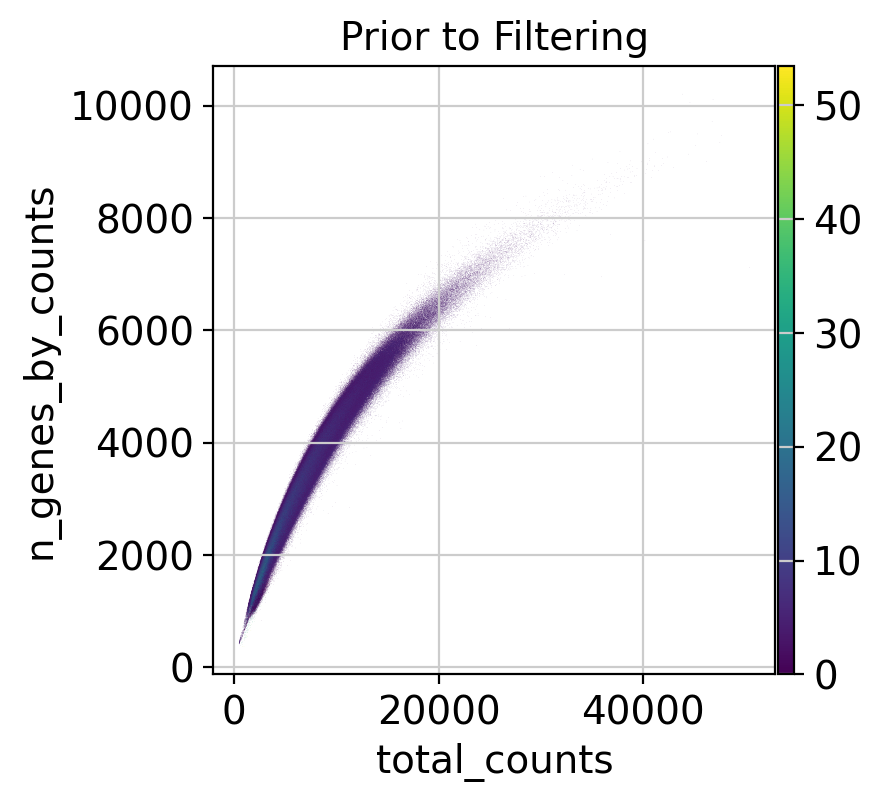

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

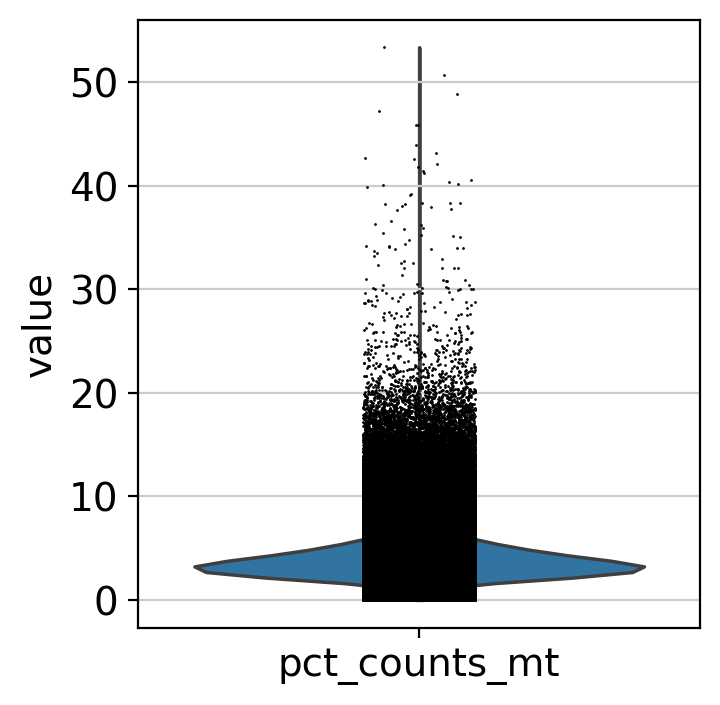

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

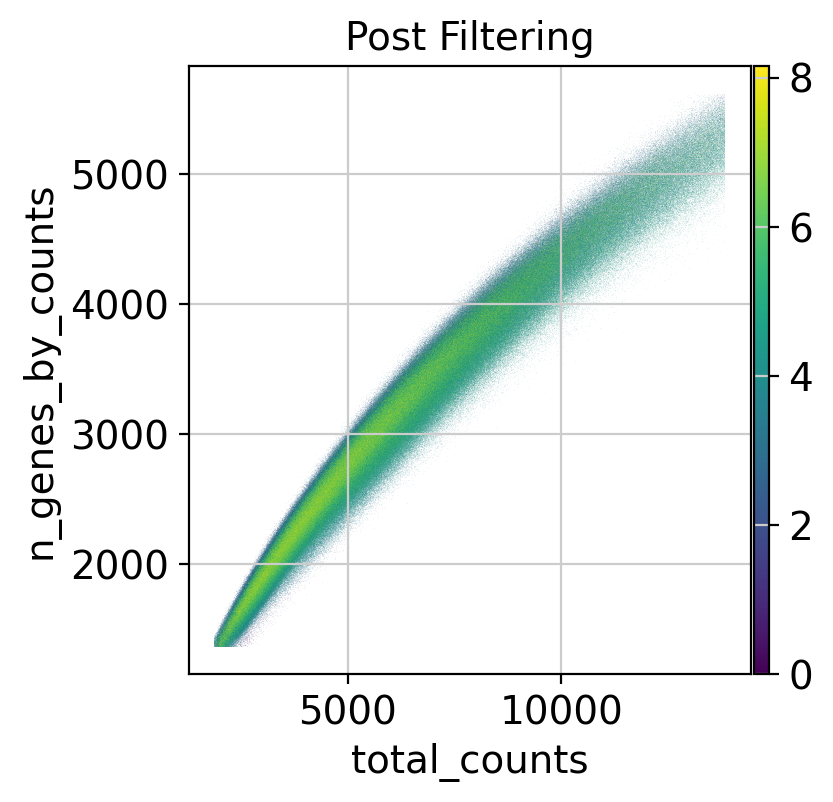

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


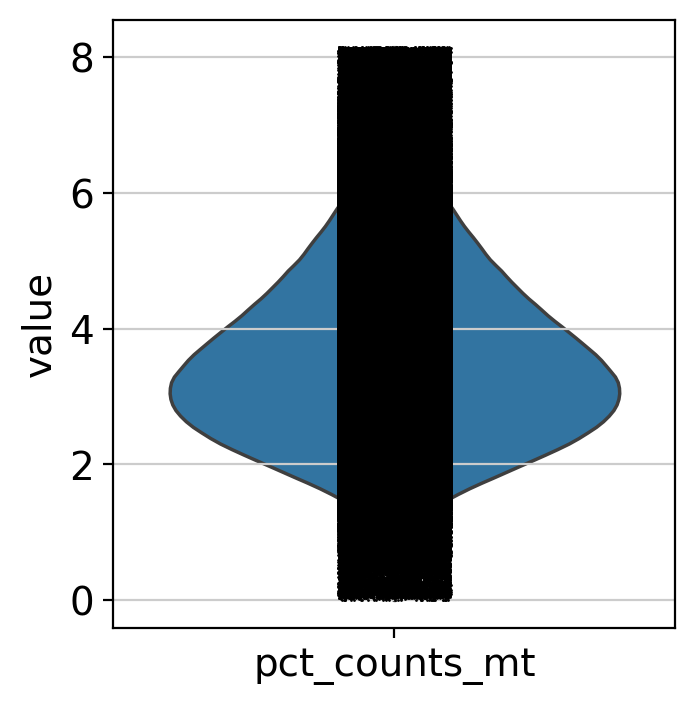

Performing doublet detection sanity check...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

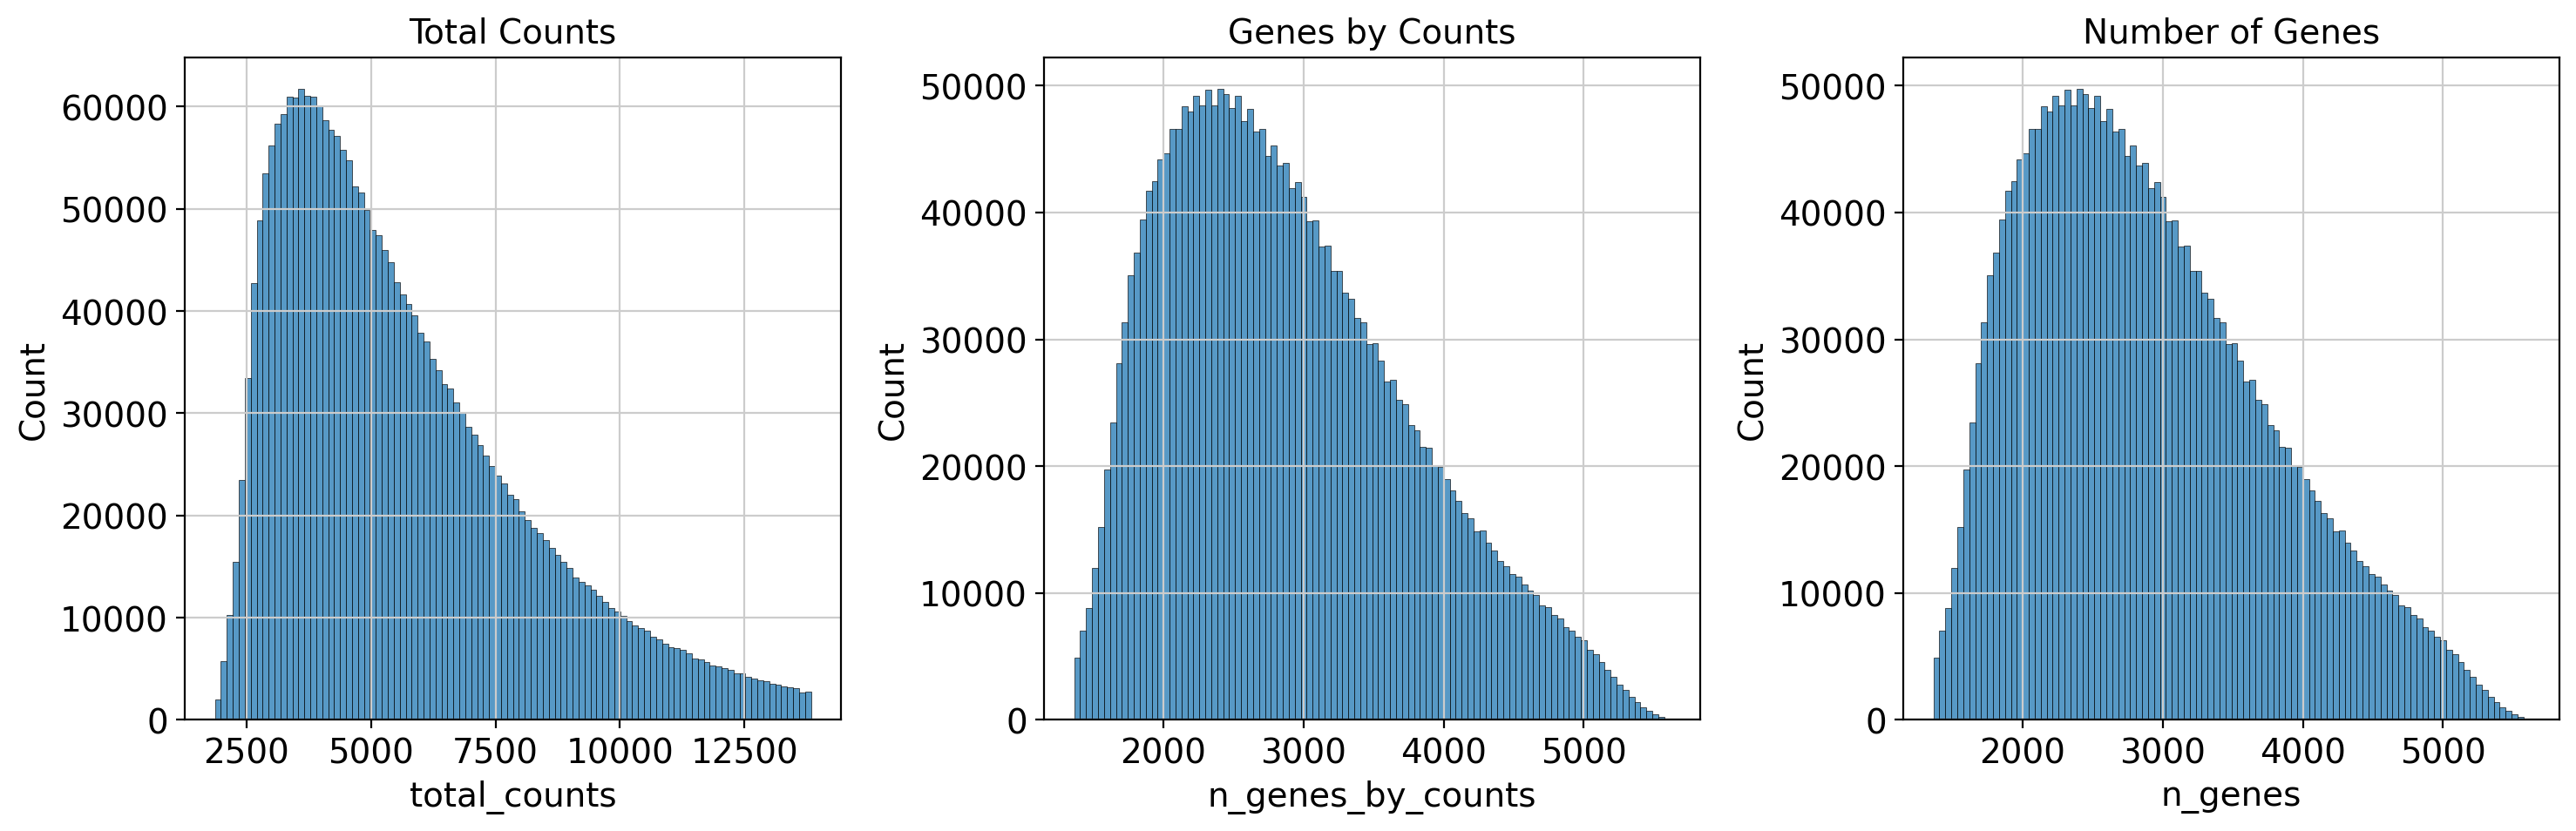

Saving final QC file to /home/ranwyl/data_tf_project/KOLF_Pan_Genome_QC_Filtered.h5ad...


View of AnnData object with n_obs × n_vars = 2498824 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'batch', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [4]:
pre_qc_file_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Pre_QC.h5ad"
final_save_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_QC_Filtered.h5ad"
count_MADs = 3 # Different from default 5

qc_input_dict = {"count_MADs": count_MADs, "final_save_path": final_save_path}

adata = psp.utils.read_anndata(pre_qc_file_path)
tf_project_general_qc_cell_qc(adata, qc_input_dict)

Restart kernel

# Filtering Cells and Genes

Filter cells, keeping NTC cells that passed fitness testing and TF KD cells only. Then filter genes, removing lowly expressed genes (but keeping all TFs in the gene list).

In [2]:
post_qc_file_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_QC_Filtered.h5ad"
adata = psp.utils.read_anndata(post_qc_file_path)

In [3]:
adata.obs.perturbed.value_counts()

perturbed
True     2360549
False     138275
Name: count, dtype: int64

In [3]:
import anndata as ad

def filter_ntc_whitelist_and_tf_kd_cells(adata, ntc_filepath, tf_set):
    """
    Filter NTC cells based on provided whitelist of NTC cells that passed fitness testing.
    Filter perturbed cells with TF gene targets based on provided set of TFs.
    """
    with open(ntc_filepath, "r") as f:
        sgRNA_whitelist = f.read().splitlines()
    return adata[(adata.obs.gRNA.isin(sgRNA_whitelist)) | (adata.obs.gene_target.isin(tf_set))].copy()

In [4]:
import pandas as pd

# List of 1639 TFs from Lambert et al (2018)
tf_filepath = "/home/ranwyl/data_tf_project/input_files/Lambert_2018_TFs.csv"
tf_csv = pd.read_csv(tf_filepath)
lambert_tfs = set(tf_csv[tf_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist())

# NTC whitelist
whitelist_filepath = "/home/ranwyl/data_tf_project/input_files/NTC_sgRNA_whitelist.txt"

# Filter cells
adata = filter_ntc_whitelist_and_tf_kd_cells(adata, whitelist_filepath, lambert_tfs)

In [6]:
adata.obs.perturbed.value_counts()

perturbed
True     401383
False     50329
Name: count, dtype: int64

In [7]:
adata[adata.obs.batch == "ALPHA"].obs.perturbed.value_counts()

perturbed
True     397862
False     19571
Name: count, dtype: int64

In [15]:
adata[adata.obs.batch == "BETA"].obs.perturbed.value_counts()

perturbed
False    18303
True      2482
Name: count, dtype: int64

In [16]:
adata[adata.obs.batch == "GAMMA"].obs.perturbed.value_counts()

perturbed
False    12455
True      1039
Name: count, dtype: int64

See which TF KDs are in each batch

In [11]:
def display_kds_per_batch(adata, batch_key, n_to_display):
    batches = adata.obs[batch_key].unique().tolist()
    for batch in batches:
        batch_kds = adata[adata.obs[batch_key] == batch].obs.gene_target.unique().tolist()
        if len(batch_kds) <= n_to_display:
            print(f"Batch {batch} has {len(batch_kds)} KDs: {', '.join(batch_kds)}")
        else:
            print(f"Batch {batch} has {len(batch_kds)} KDs")

In [12]:
display_kds_per_batch(adata, "batch", 20)

Batch ALPHA has 1593 KDs
Batch BETA has 12 KDs: NTC, SNAPC5, ZBED5, AKAP8L, MTERF4, MSANTD4, TRAFD1, PIN1, DZIP1, RBCK1, NAIF1, CCDC17
Batch GAMMA has 8 KDs: NTC, FAM200B, THYN1, MSANTD3, PRR12, RBSN, SGSM2, MTERF2


Check if batch BETA and GAMMA TFs KDS are in DoRothEA levels A/B

In [ ]:
import decoupler as dc

dorothea_df = dc.op.dorothea(organism="human", levels=["A", "B"])
dorothea_dict = dict()
for tf, gene in dorothea_df.iloc[:,:2].itertuples(index=False, name=None):
    if tf not in dorothea_dict:
        dorothea_dict[tf] = set()
    dorothea_dict[tf].add(gene)

beta_gamma_tfs = ['CCDC17', 'MSANTD4', 'SNAPC5', 'ZBED5', 'MTERF4', 'NAIF1', 
'AKAP8L', 'PURB', 'RBCK1', 'ZBED6', 'PIN1', 'TRAFD1', 'DZIP1', 'FAM200B', 
'MTERF2', 'MSANTD3', 'PRR12', 'SGSM2', 'THYN1', 'ZBED6', 'RBSN']

known_tfs = set(dorothea_dict.keys())
for tf in beta_gamma_tfs:
    if tf in known_tfs:
        print(tf)

Batch ALPHA has the vast majority of TF KDs. To avoid any complications with batch-aware HVG selection further in the pipeline, we will go on to analyze batch ALPHA only.

In [5]:
adata_alpha = adata[adata.obs.batch == "ALPHA"].copy()

In [6]:
del adata
gc.collect()

61183

Next, filter genes expressed in <100 cells, then filter 30% of genes with lowest expression

In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'
import seaborn as sns
import scanpy as sc

def filter_low_expressed_genes(adata, tf_set, percent_threshold=0, min_n_cells=0, silent=False):
    """
    Filter out bottom percentile of genes with lowest expression (counts) 
    and genes expressed in fewer than min_n_cells cells.
    Do not filter out genes that are TFs in tf_set.
    """
    n_genes_before = adata.shape[1]

    # Filter genes expressed in fewer than min_n_cells cells
    if silent == False:
        print(f"Removing non-TF genes expressed in <{min_n_cells} cells")
    # Create data matrix
    if silent == False:
        print("Copying data")
    data_matrix = adata.layers["counts"] if "counts" in adata.layers else adata.X
    data_matrix = data_matrix.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    if silent == False:
        print("Filtering genes")
    # Create mask for TFs
    tf_mask = adata.var_names.isin(tf_set)
    # Calculate number of cells expressing each gene
    gene_detected_counts = (data_matrix > 0).sum(axis=0)
    # Set cell number threshold and filter genes
    genes_pass_cell_thr = gene_detected_counts >= min_n_cells
    genes_to_keep = genes_pass_cell_thr | tf_mask
    adata = adata[:, genes_to_keep]
    print(f"Removed {n_genes_before - adata.n_vars} "
        f"non-TF genes expressed in <{min_n_cells} cells")
    n_genes_after_cell_filt = adata.n_vars
    del data_matrix

    # Filter bottom percentile of genes by expression (counts)
    if silent == False:
        print(f"\nRemoving bottom {percent_threshold}% of genes by expression (CPM)")
    if silent == False:
        print("Copying data")
    adata_norm = adata.copy()
    sc.pp.normalize_total(adata_norm, target_sum=1e6)
    if silent == False:
        print("Copying normalized data")
    data_matrix = adata_norm.X.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    if silent == False:
        print("Filtering genes")
    # Create mask for TFs
    tf_mask = adata.var_names.isin(tf_set)
    # Calculate mean expression of each gene
    mean_expr_per_gene = data_matrix.mean(axis=0)
    # Set percent threshold and filter genes
    threshold = np.percentile(mean_expr_per_gene, percent_threshold)
    genes_pass_pct_thr = mean_expr_per_gene > threshold
    genes_to_keep = genes_pass_pct_thr | tf_mask
    adata = adata[:,genes_to_keep]
    print(f"Removed {n_genes_after_cell_filt - adata.n_vars} non-TF genes "
            f"with lowest {percent_threshold}% expression (CPM)")
    print(f"\nRemoved: {n_genes_before - adata.shape[1]} genes total")
    print(f"Remaining: {adata.n_vars} genes")
    del data_matrix
    del adata_norm
    gc.collect()
    return adata.copy()

def histogram_mean_expression(adata, title="Histogram of Mean Gene Expression", 
                              n_bins=75, ymax=None, show_labels=False):
    plt.rcParams["font.size"] = 14
    # Create data matrix
    adata = adata.copy()
    if "counts" in adata.layers:
        adata.X = adata.layers["counts"].copy()
    # Normalize and log1p
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.log1p(adata)
    # Copy
    data_matrix = adata.X.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        data_matrix = data_matrix.toarray()

    # Plot mean expression
    mean_expr = data_matrix.mean(axis=0)
    plt.figure(figsize=(8,4)) if show_labels else plt.figure(figsize=(6,4))
    ax = sns.histplot(mean_expr, bins=n_bins, kde=False)
    plt.xlabel("Mean expression per gene (CPM, log1p)")
    plt.ylabel("Number of genes")
    plt.title(title, fontsize=15)
    if ymax:
        ax.set_ylim(0, ymax)
    if show_labels:
        ax.bar_label(ax.containers[0], rotation=90, padding=3, fontsize=10)
    plt.tight_layout()
    plt.show()
    del data_matrix
    gc.collect()

def histogram_cells_expressing_gene(adata, title="Histogram of # Cells Expressing a Gene", 
                                    n_bins=75, ymax=None, show_labels=False):
    plt.rcParams["font.size"] = 14
    # Use raw counts
    count_matrix = adata.X if "counts" not in adata.layers else adata.layers["counts"]
    count_matrix = count_matrix.copy()
    # Convert from sparse to dense if necessary
    if hasattr(count_matrix, 'toarray'):
        count_matrix = count_matrix.toarray()
    # Plot number of cells expressing each gene
    gene_detected_counts = (count_matrix > 0).sum(axis=0)
    plt.figure(figsize=(8,4)) if show_labels else plt.figure(figsize=(6,4))
    ax = sns.histplot(gene_detected_counts, bins=n_bins, kde=False)
    plt.xlabel("Number of cells in which gene is expressed")
    plt.ylabel("Number of genes")
    plt.title(title, fontsize=15)
    if ymax:
        ax.set_ylim(0, ymax)
    if show_labels:
        ax.bar_label(ax.containers[0], rotation=90, padding=3, fontsize=10)
    plt.tight_layout()
    plt.show()
    del count_matrix
    gc.collect()

Plot histograms before filtering

normalizing counts per cell
    finished (0:00:02)


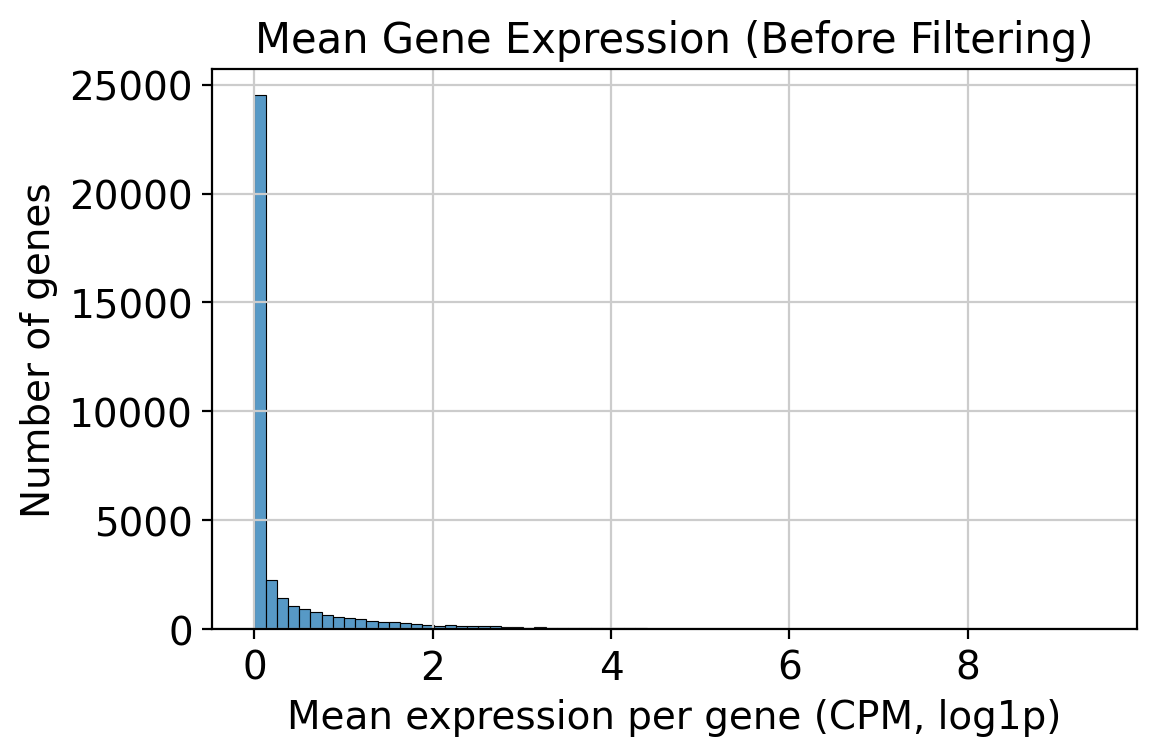

In [14]:
histogram_mean_expression(adata_alpha, "Mean Gene Expression (Before Filtering)")

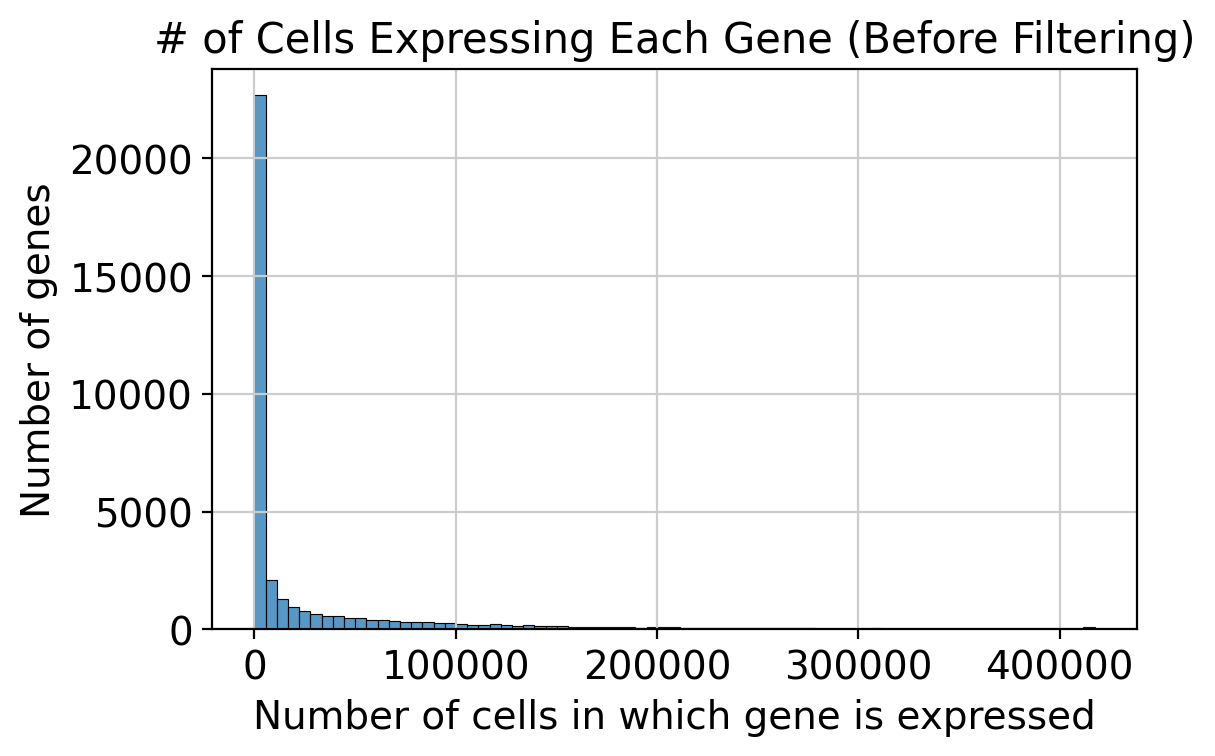

In [24]:
histogram_cells_expressing_gene(adata_alpha, 
                                "# of Cells Expressing Each Gene (Before Filtering)")

Filter

In [11]:
adata_filtered = filter_low_expressed_genes(adata_alpha, lambert_tfs, 
                                            percent_threshold=30, min_n_cells=100)

Removing non-TF genes expressed in <100 cells
Copying data
Converting data from sparse to dense
Filtering genes
Removed 9505 non-TF genes expressed in <100 cells

Removing bottom 30% of genes by expression (CPM)
Copying data
normalizing counts per cell
    finished (0:00:02)
Copying normalized data
Converting data from sparse to dense
Filtering genes
Removed 8019 non-TF genes with lowest 30% expression (CPM)

Removed: 17524 genes total
Remaining: 20043 genes


Try filtering with log1p step included

In [ ]:
import numpy as np
import scanpy as sc

def filter_low_expressed_genes_norm_log1p(adata, tf_set, percent_threshold=0, 
                                          min_n_cells=0, silent=False):
    """
    Filter out bottom percentile of genes with lowest expression (counts) 
    and genes expressed in fewer than min_n_cells cells.
    Do not filter out genes that are TFs in tf_set.
    """
    n_genes_before = adata.shape[1]

    # Filter genes expressed in fewer than min_n_cells cells
    if silent == False:
        print(f"Removing non-TF genes expressed in <{min_n_cells} cells")
    # Create data matrix
    if silent == False:
        print("Copying data")
    data_matrix = adata.layers["counts"] if "counts" in adata.layers else adata.X
    data_matrix = data_matrix.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    if silent == False:
        print("Filtering genes")
    # Create mask for TFs
    tf_mask = adata.var_names.isin(tf_set)
    # Calculate number of cells expressing each gene
    gene_detected_counts = (data_matrix > 0).sum(axis=0)
    # Set cell number threshold and filter genes
    genes_pass_cell_thr = gene_detected_counts >= min_n_cells
    genes_to_keep = genes_pass_cell_thr | tf_mask
    adata = adata[:, genes_to_keep]
    print(f"Removed {n_genes_before - adata.n_vars} "
        f"non-TF genes expressed in <{min_n_cells} cells")
    n_genes_after_cell_filt = adata.n_vars
    del data_matrix

    # Filter bottom percentile of genes by expression (counts)
    if silent == False:
        print(f"\nRemoving bottom {percent_threshold}% of genes by expression (CPM)")
    if silent == False:
        print("Copying data")
    adata_norm = adata.copy()
    sc.pp.normalize_total(adata_norm, target_sum=1e6)
    sc.pp.log1p(adata_norm)
    if silent == False:
        print("Copying normalized, log1p-transformed data")
    data_matrix = adata_norm.X.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    if silent == False:
        print("Filtering genes")
    # Create mask for TFs
    tf_mask = adata.var_names.isin(tf_set)
    # Calculate mean expression of each gene
    mean_expr_per_gene = data_matrix.mean(axis=0)
    # Set percent threshold and filter genes
    threshold = np.percentile(mean_expr_per_gene, percent_threshold)
    genes_pass_pct_thr = mean_expr_per_gene > threshold
    genes_to_keep = genes_pass_pct_thr | tf_mask
    adata = adata[:,genes_to_keep]
    print(f"Removed {n_genes_after_cell_filt - adata.n_vars} non-TF genes "
            f"with lowest {percent_threshold}% expression (CPM)")
    print(f"\nRemoved: {n_genes_before - adata.shape[1]} genes total")
    print(f"Remaining: {adata.n_vars} genes")
    del data_matrix
    del adata_norm
    gc.collect()
    return adata.copy()

In [8]:
adata_filtered_log1p = \
    filter_low_expressed_genes_norm_log1p(adata_alpha, lambert_tfs, 
                                        percent_threshold=30, min_n_cells=100)

Removing non-TF genes expressed in <100 cells
Copying data
Converting data from sparse to dense
Filtering genes
Removed 9505 non-TF genes expressed in <100 cells

Removing bottom 30% of genes by expression (CPM)
Copying data
normalizing counts per cell
    finished (0:00:02)
Copying normalized, log1p-transformed data
Converting data from sparse to dense
Filtering genes
Removed 8019 non-TF genes with lowest 30% expression (CPM)

Removed: 17524 genes total
Remaining: 20043 genes


Try filter where expression is normalized to the median of total cell counts (instead of CPM)

In [9]:
import numpy as np
import scanpy as sc

def filter_low_expressed_genes_median_norm(adata, tf_set, percent_threshold=0, 
                                           min_n_cells=0, silent=False):
    """
    Filter out bottom percentile of genes with lowest expression (counts) 
    and genes expressed in fewer than min_n_cells cells.
    Do not filter out genes that are TFs in tf_set.
    """
    n_genes_before = adata.shape[1]

    # Filter genes expressed in fewer than min_n_cells cells
    if silent == False:
        print(f"Removing non-TF genes expressed in <{min_n_cells} cells")
    # Create data matrix
    if silent == False:
        print("Copying data")
    data_matrix = adata.layers["counts"] if "counts" in adata.layers else adata.X
    data_matrix = data_matrix.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    if silent == False:
        print("Filtering genes")
    # Create mask for TFs
    tf_mask = adata.var_names.isin(tf_set)
    # Calculate number of cells expressing each gene
    gene_detected_counts = (data_matrix > 0).sum(axis=0)
    # Set cell number threshold and filter genes
    genes_pass_cell_thr = gene_detected_counts >= min_n_cells
    genes_to_keep = genes_pass_cell_thr | tf_mask
    adata = adata[:, genes_to_keep]
    print(f"Removed {n_genes_before - adata.n_vars} "
        f"non-TF genes expressed in <{min_n_cells} cells")
    n_genes_after_cell_filt = adata.n_vars
    del data_matrix

    # Filter bottom percentile of genes by expression (counts)
    if silent == False:
        print(f"\nRemoving bottom {percent_threshold}% of genes by expression (CPM)")
    if silent == False:
        print("Copying data")
    adata_norm = adata.copy()
    sc.pp.normalize_total(adata_norm)
    if silent == False:
        print("Copying normalized data")
    data_matrix = adata_norm.X.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    if silent == False:
        print("Filtering genes")
    # Create mask for TFs
    tf_mask = adata.var_names.isin(tf_set)
    # Calculate mean expression of each gene
    mean_expr_per_gene = data_matrix.mean(axis=0)
    # Set percent threshold and filter genes
    threshold = np.percentile(mean_expr_per_gene, percent_threshold)
    genes_pass_pct_thr = mean_expr_per_gene > threshold
    genes_to_keep = genes_pass_pct_thr | tf_mask
    adata = adata[:,genes_to_keep]
    print(f"Removed {n_genes_after_cell_filt - adata.n_vars} non-TF genes "
            f"with lowest {percent_threshold}% expression (CPM)")
    print(f"\nRemoved: {n_genes_before - adata.shape[1]} genes total")
    print(f"Remaining: {adata.n_vars} genes")
    del data_matrix
    del adata_norm
    gc.collect()
    return adata.copy()

In [10]:
adata_filtered_median_norm = \
    filter_low_expressed_genes_median_norm(adata_alpha, lambert_tfs, 
                                           percent_threshold=30, min_n_cells=100)

Removing non-TF genes expressed in <100 cells
Copying data
Converting data from sparse to dense
Filtering genes
Removed 9505 non-TF genes expressed in <100 cells

Removing bottom 30% of genes by expression (CPM)
Copying data
normalizing counts per cell
    finished (0:00:02)
Copying normalized data
Converting data from sparse to dense
Filtering genes
Removed 8019 non-TF genes with lowest 30% expression (CPM)

Removed: 17524 genes total
Remaining: 20043 genes


Plot histograms after filtering

normalizing counts per cell
    finished (0:00:02)


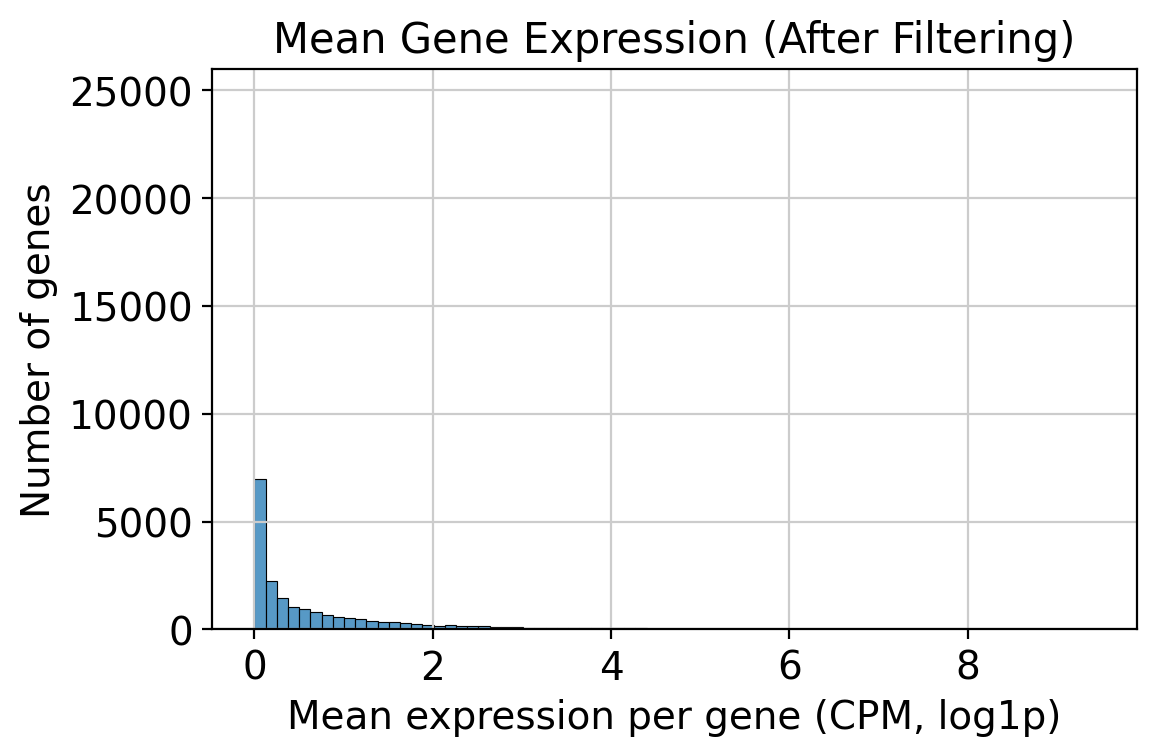

In [15]:
histogram_mean_expression(adata_filtered, 
                          "Mean Gene Expression (After Filtering)", ymax=26000)

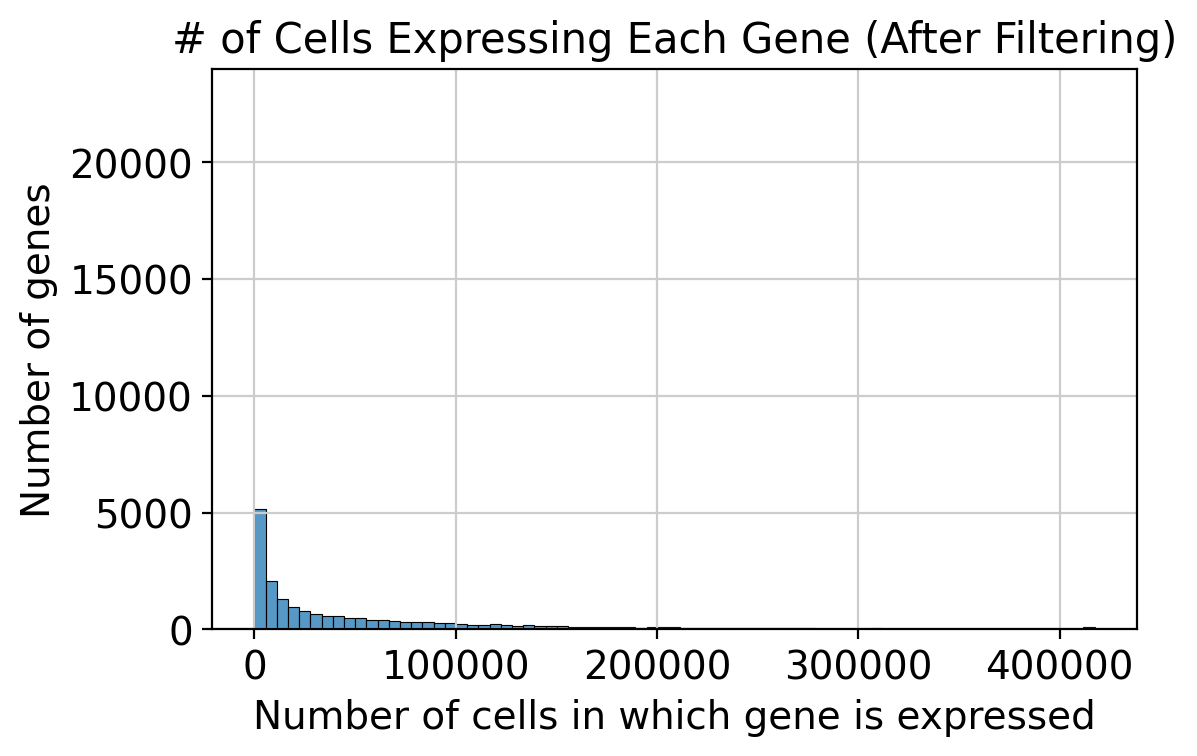

In [16]:
histogram_cells_expressing_gene(adata_filtered, 
                                "# of Cells Expressing Each Gene (After Filtering)", ymax=24000)

Save file

In [12]:
adata_filtered.write("/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_QC_Cell_Gene_Filtered.h5ad")

Restart kernel

# Scrubbing NTC Cells

Use PCA and isolation forest model to remove outlier NTC cells. Use random seed = 42 for isolation forest.

In [2]:
import anndata as ad
import scanpy as sc
from sklearn.ensemble import IsolationForest

def _tf_project_scrub_ntc_isolation_forest(adata: ad.AnnData, 
                                           contamination_threshold: float,  
                                           batch_key: str = 'batch', 
                                           sgRNA_column: str = "gRNA", 
                                           min_cells_per_NTC_guide: int = 25,
                                           random_state: int = 42) -> list:
    """
    Version of psp.pp._scrub_ntc_isolation_forest that uses a random seed
    for scikit-learn IsolationForest.
    """
    # Use PCA representation for outlier detection
    if "X_pca_harmony" in adata.obsm:
        rep = "X_pca_harmony"
    else:
        rep = "X_pca"
    data = adata.obsm[rep]
    
    # Fit the Isolation Forest model
    clf = IsolationForest(contamination=contamination_threshold, random_state=random_state)
    clf.fit(data)
    
    # Classify points as outliers (-1) and inliers (1)
    labels = clf.predict(data)
    adata.obs['is_outlier'] = labels
    adata.obs['is_outlier'] = adata.obs['is_outlier'].replace({-1: 'outlier', 1: 'inlier'})
    
    # Visualize the outlier classification Pre-Filtering
    sc.pp.neighbors(adata, use_rep=rep)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=["is_outlier", "phase", "batch"], title="Pre-Filtering", frameon=False)
    sc.tl.embedding_density(adata)
    sc.pl.embedding_density(adata, frameon=False)
    
    # Filter out outliers and visualize Post-Filtering
    adata_filtered = adata[adata.obs.is_outlier == "inlier", :]

    # Filter out NTCs with too few cells
    if batch_key is not None:
        batch_counts = adata_filtered.obs.groupby([sgRNA_column, batch_key]).size().unstack(fill_value=0)
        guides_to_keep = batch_counts[batch_counts.min(axis=1) >= min_cells_per_NTC_guide].index.tolist()
        print(f"Removing {len(batch_counts) - len(guides_to_keep)} NTC guides due to having less than {min_cells_per_NTC_guide} cells in each batch")
        adata_filtered = adata_filtered[adata_filtered.obs[sgRNA_column].isin(guides_to_keep)]
    
    else:
        counts = adata_filtered.obs[sgRNA_column].value_counts()
        guides_to_keep = counts[counts >= min_cells_per_NTC_guide].index.tolist()
        print(f"Removing {len(counts) - len(guides_to_keep)} NTC guides due to having less than {min_cells_per_NTC_guide} cells")
        adata_filtered = adata_filtered[adata_filtered.obs[sgRNA_column].isin(guides_to_keep)]

    sc.pp.neighbors(adata_filtered, use_rep=rep)
    sc.tl.umap(adata_filtered, )
    sc.pl.umap(adata_filtered, color=["is_outlier", "phase", "batch"], title="Post-Filtering", frameon=False)
    sc.tl.embedding_density(adata_filtered)
    sc.pl.embedding_density(adata_filtered, frameon=False)
    
    return list(adata_filtered.obs.index)

def tf_project_clean_ntc_cells(adata: ad.AnnData, 
                               contamination_threshold: float = 0.3, 
                               batch_key: str = None, 
                               sgRNA_column: str = "gRNA", 
                               min_cells_per_NTC_guide: int = 25,
                               random_state: int = 42) -> ad.AnnData:
    """
    Version of psp.pp.clean_ntc_cells() that takes a random seed
    for scikit-learn IsolationForest.
    """
    # Assertions to ensure required fields are present
    assert 'counts' in adata.layers, "The AnnData object must have a 'counts' layer."
    assert 'perturbed' in adata.obs, "The AnnData object must have a 'perturbed' column in obs which indicates whether the cell is perturbed or not."
    if batch_key is not None:
        assert batch_key in adata.obs, f"The AnnData object must have a {batch_key} column in obs which indicates the batch the cell belongs to."

    adata_ntc = psp.utils.get_ntc_view(adata).copy()
    print(f"Initial number of NTC Cells: {len(adata_ntc)}")

    # NTC whitelist cells have already been filtered
    
    # Perform PCA on the data
    if batch_key is not None:
        psp.pp.preprocessing._scrub_ntc_pca(adata_ntc, batch_key = batch_key)
    else:
        psp.pp.preprocessing._scrub_ntc_pca(adata_ntc)
    
    # Identify valid NTC cells using Isolation Forest
    valid_ntc_cells = _tf_project_scrub_ntc_isolation_forest(adata_ntc, contamination_threshold, batch_key, sgRNA_column, min_cells_per_NTC_guide, random_state)
    print(f"Number of NTC Cells after Isolation Forest filtering: {len(valid_ntc_cells)}")
    perturbed_mask = adata.obs.perturbed == "True"
    valid_ntc_mask = adata.obs.index.isin(valid_ntc_cells)
    valid_cells_mask = perturbed_mask | valid_ntc_mask
    adata._inplace_subset_obs(valid_cells_mask)
    print(f"Total number of cells after NTC cleaning: {len(adata.obs)}")
    print(f"Number of NTC Cells per batch \n: {psp.utils.get_ntc_view(adata).obs.batch.value_counts()}")
    return adata

In [3]:
adata_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_QC_Cell_Gene_Filtered.h5ad"
adata = psp.utils.read_anndata(adata_filepath)
adata

AnnData object with n_obs × n_vars = 417433 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'batch', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

Perform CPM normalization

In [4]:
import scanpy as sc

adata_norm = adata.copy()
sc.pp.normalize_total(adata_norm, target_sum=1e6)

normalizing counts per cell
    finished (0:00:02)


Initial number of NTC Cells: 19571
extracting highly variable genes


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    471 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    473 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


/usr/lib64/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.


computing PCA
    with n_comps=50
    finished (0:00:03)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PCs', the loadings (adata.varm)
    'pca_variance', the variance / eigenvalues (adata.uns['pca'])
    'pca_variance_ratio', the variance ratio (adata.uns['pca'])


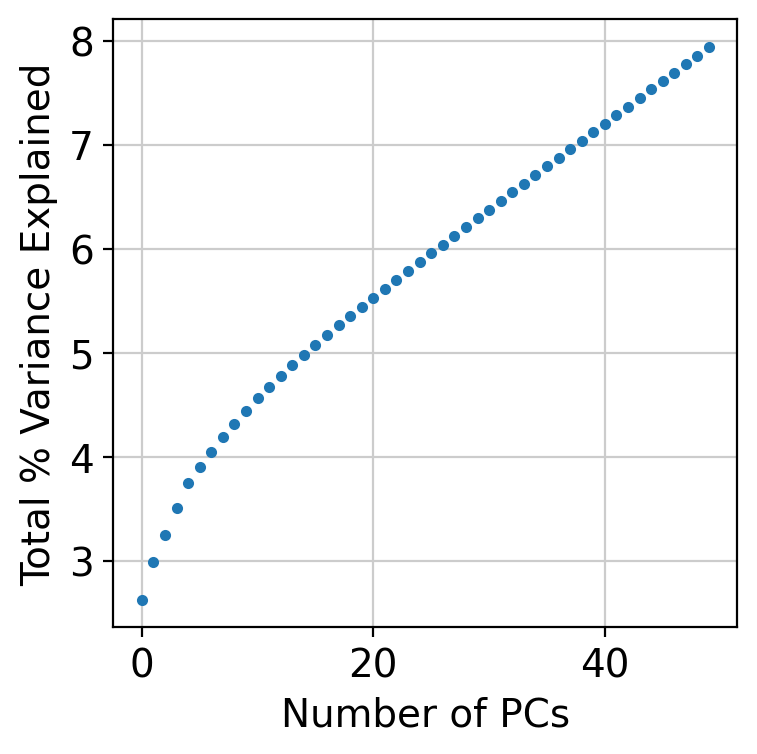

computing neighbors
    computing neighbors
    computed neighbors (0:00:20)
    computed connectivities (0:00:01)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)
computing UMAP


  0%|          | 0/200 [00:00<?, ?it/s]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:11)


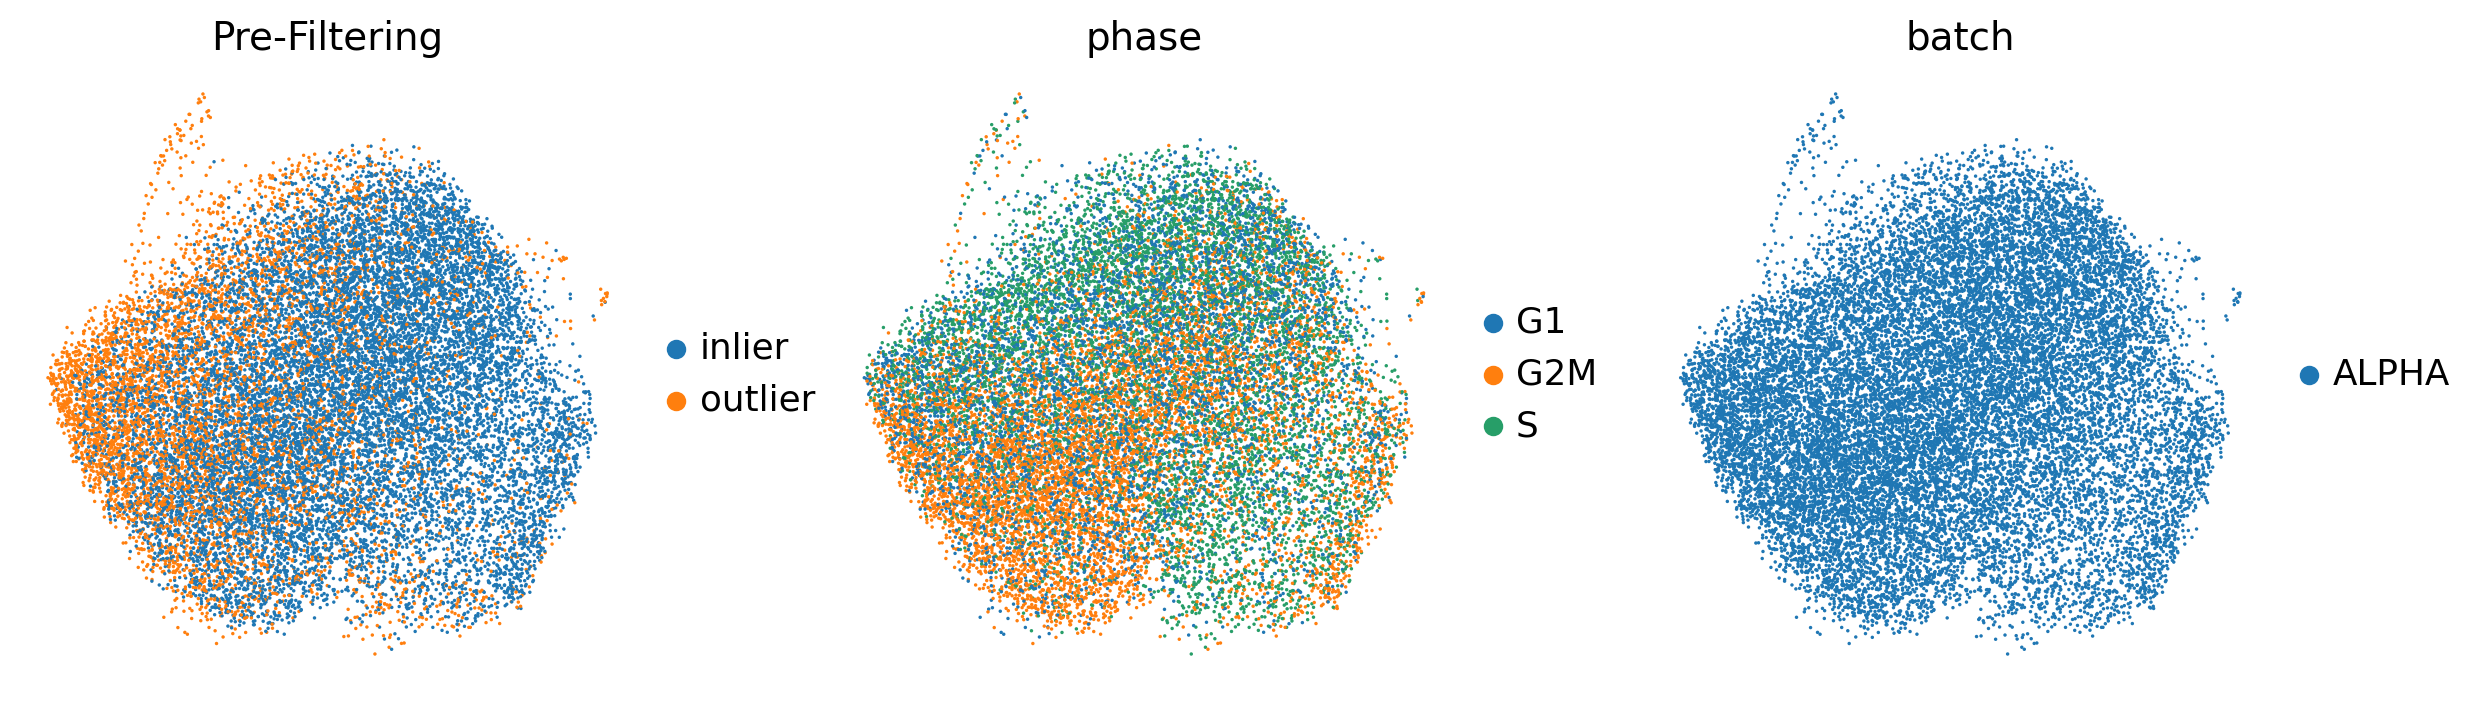

computing density on 'umap'
--> added
    'umap_density', densities (adata.obs)
    'umap_density_params', parameter (adata.uns)


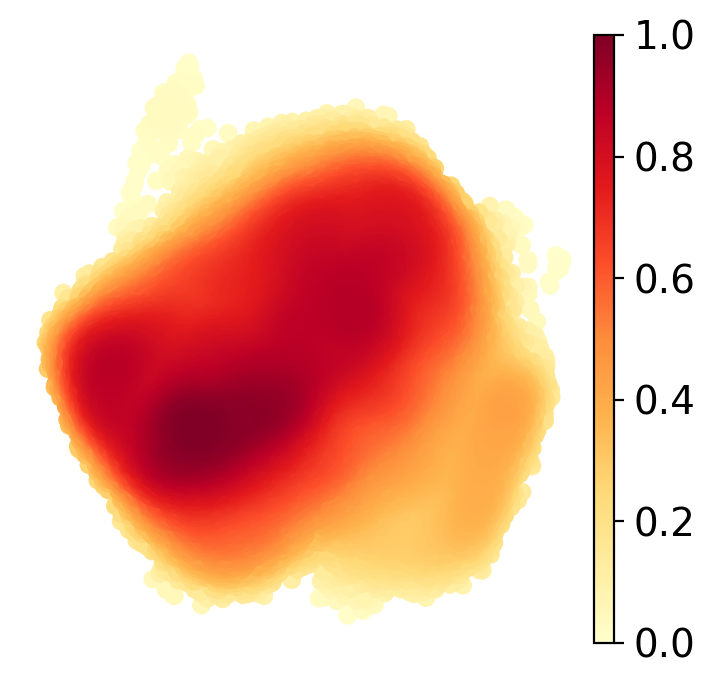

Removing 2 NTC guides due to having less than 25 cells
computing neighbors
        initialized `.distances` `.connectivities` 
    computing neighbors
    computed neighbors (0:00:02)
    computed connectivities (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP


  0%|          | 0/200 [00:00<?, ?it/s]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:07)


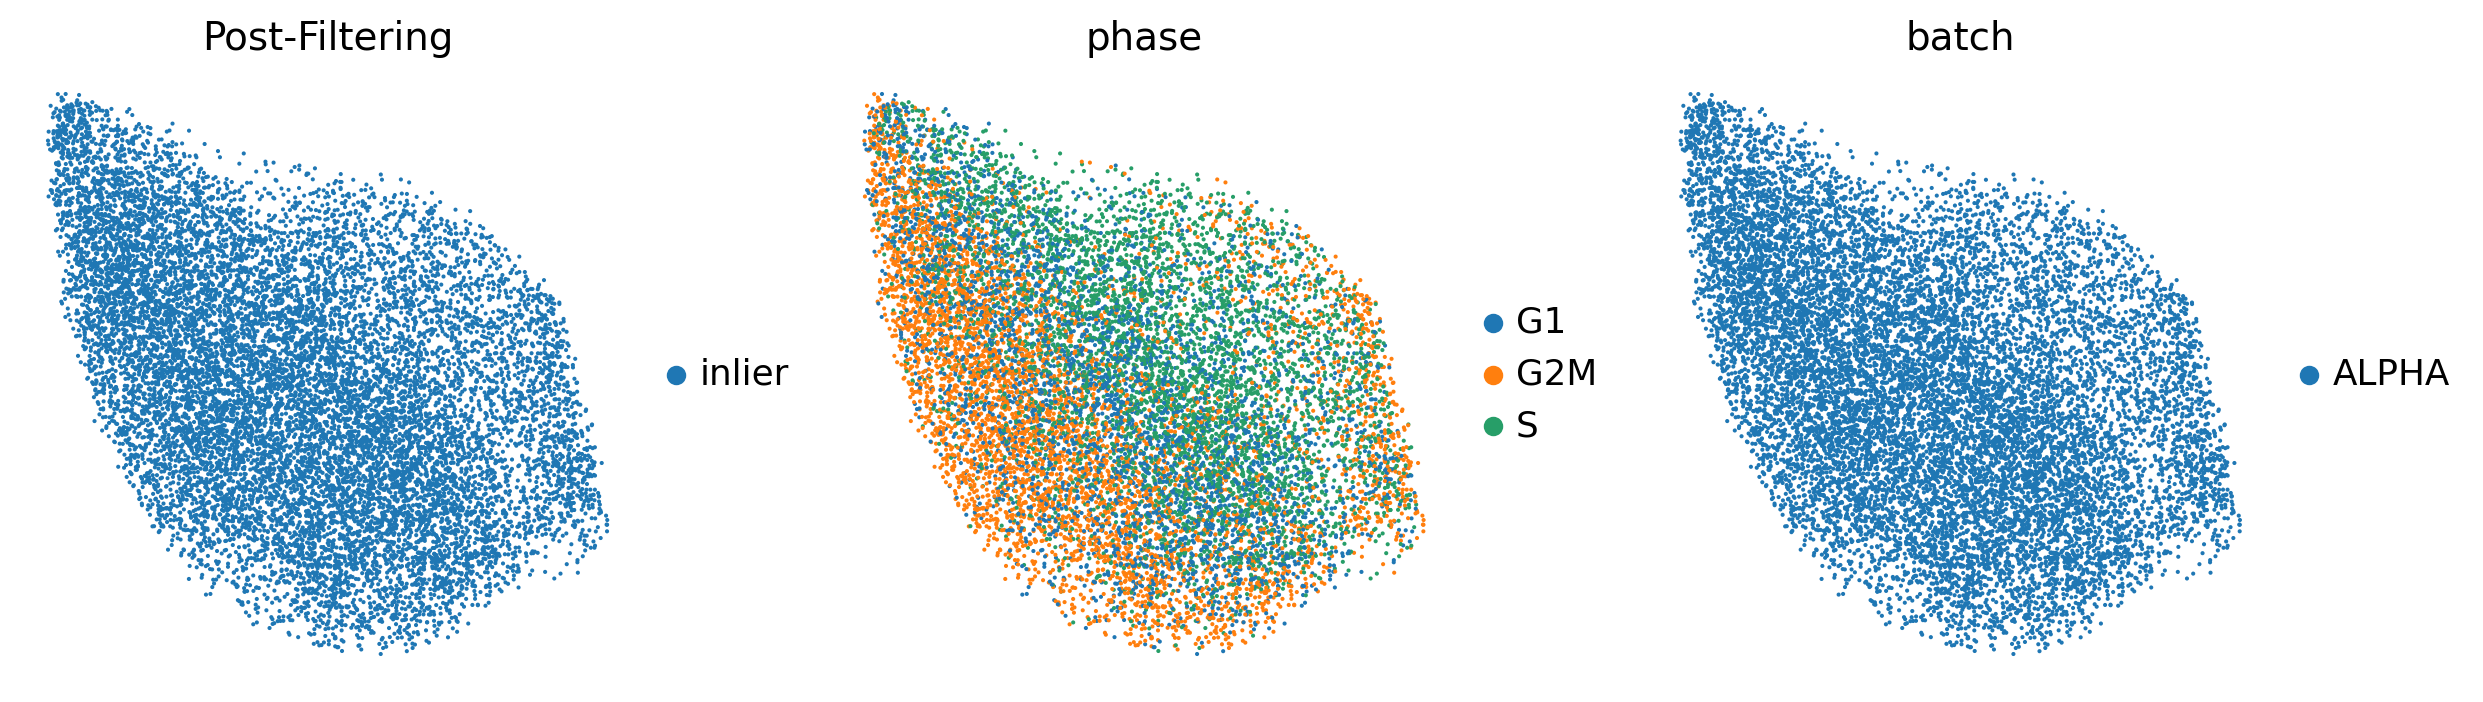

computing density on 'umap'
--> added
    'umap_density', densities (adata.obs)
    'umap_density_params', parameter (adata.uns)


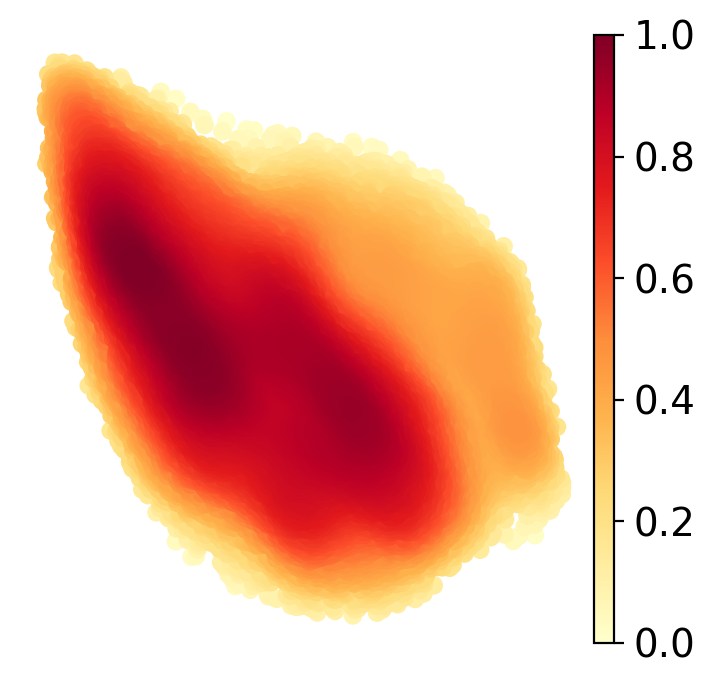

Number of NTC Cells after Isolation Forest filtering: 13674
Total number of cells after NTC cleaning: 411536
Number of NTC Cells per batch 
: batch
ALPHA    13674
Name: count, dtype: int64


In [5]:
adata_norm = tf_project_clean_ntc_cells(adata_norm, random_state=42)

In [6]:
adata_norm

AnnData object with n_obs × n_vars = 411536 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'batch', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [7]:
final_save_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_Filtered.h5ad"
adata_norm.write(final_save_path)

# Filtering sgRNAs by Knockdown Efficiency

Calculate knockdown efficiency

In [8]:
data_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_Filtered.h5ad"
adata = psp.utils.read_anndata(data_path)
adata

AnnData object with n_obs × n_vars = 411536 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'batch', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

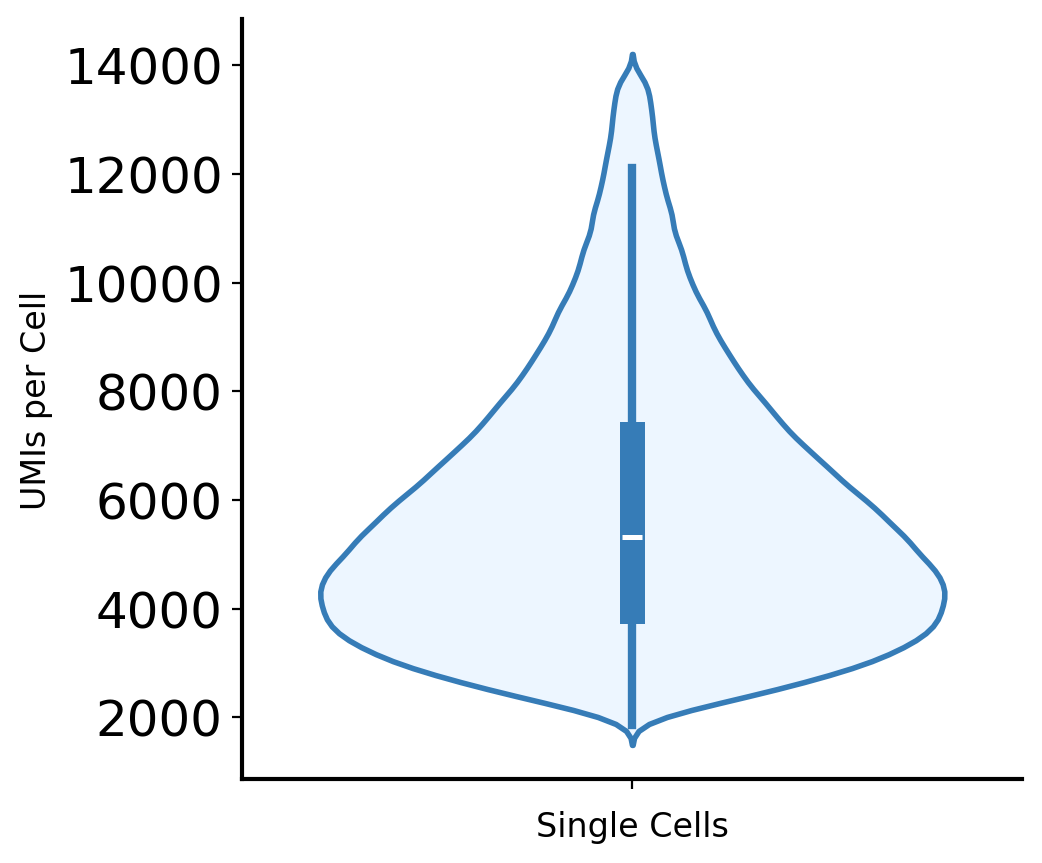

In [9]:
fig = psp.pl.plot_umis_per_cell(adata)

In [10]:
adata = psp.pp.knockdown_qc(adata, batch_aware=False)

normalizing counts per cell
    finished (0:00:02)


In [11]:
adata

AnnData object with n_obs × n_vars = 411536 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'batch', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

Plot number of cells per sgRNA (there can be multiple sgRNA per gene target)

4608/4762 (96.77%) have > 25 cells


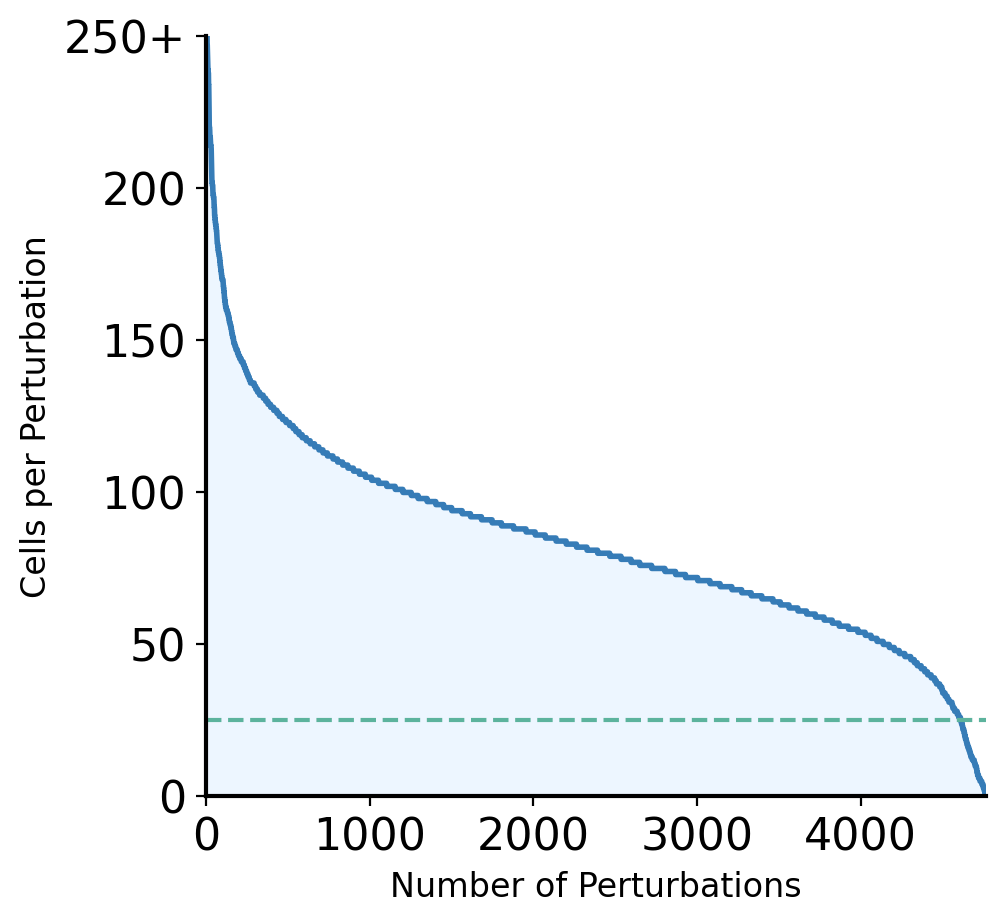

In [12]:
fig = psp.pl.plot_cells_per_perturbation(adata, perturbation_key = 'perturbation', xlabel='Number of Perturbations', ylabel='Cells per Perturbation', highlight_threshold=25, y_max=250, tick_spacing=50)

Plot number of cells per gene target

1562/1592 (98.12%) have > 100 cells


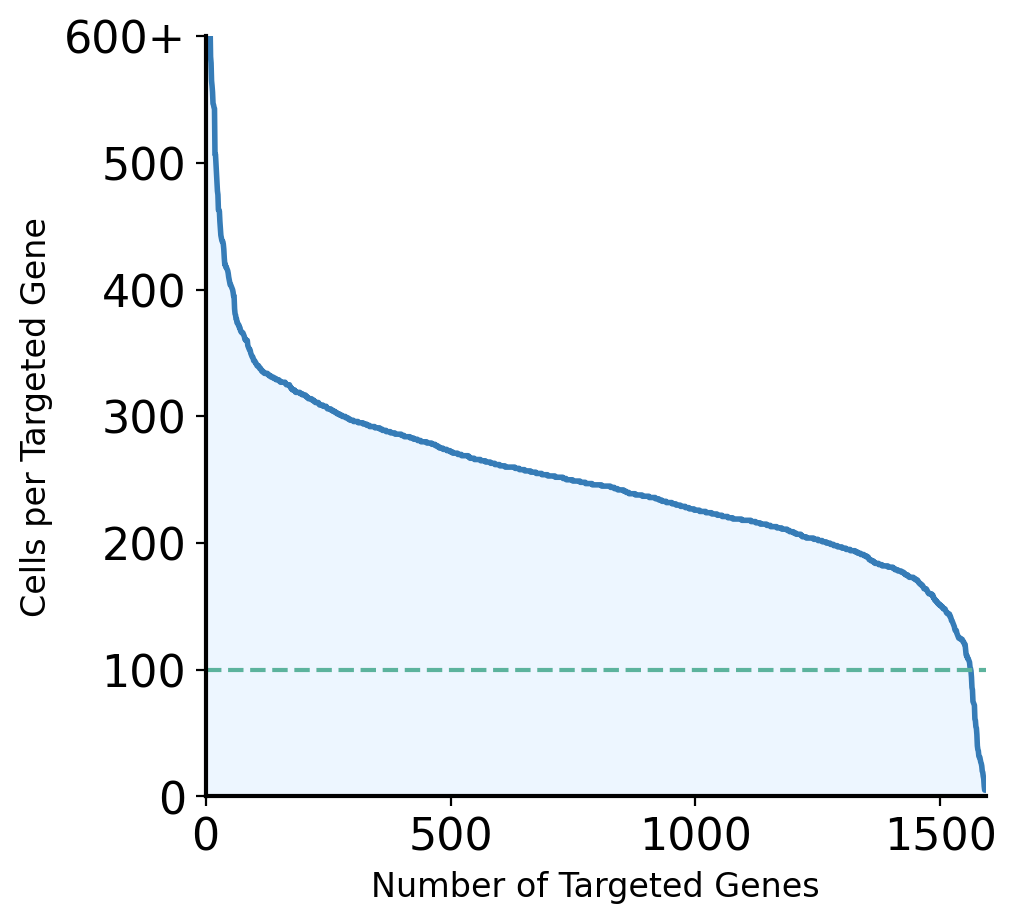

In [13]:
fig = psp.pl.plot_cells_per_perturbation(adata, perturbation_key = 'gene_target', xlabel='Number of Targeted Genes', ylabel='Cells per Targeted Gene')

Plot percentage repression per sgRNA

Percentage of perturbations achieving 30.0% repression: 72.64% (3459/4762)


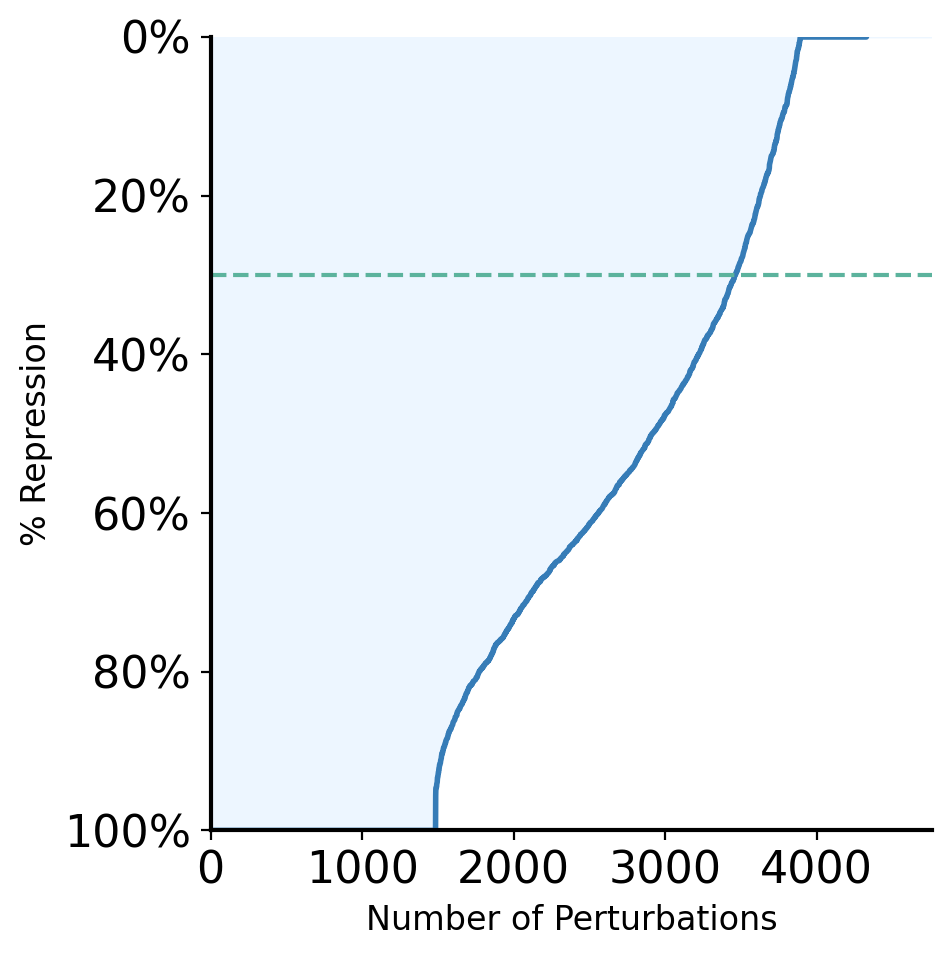

In [14]:
fig2 = psp.pl.plot_percentage_perturbations_by_repression(adata, perturbation_col='perturbation', xlabel='Number of Perturbations')

Plot percentage repression per gene target

Percentage of perturbations achieving 30.0% repression: 73.30% (1167/1592)


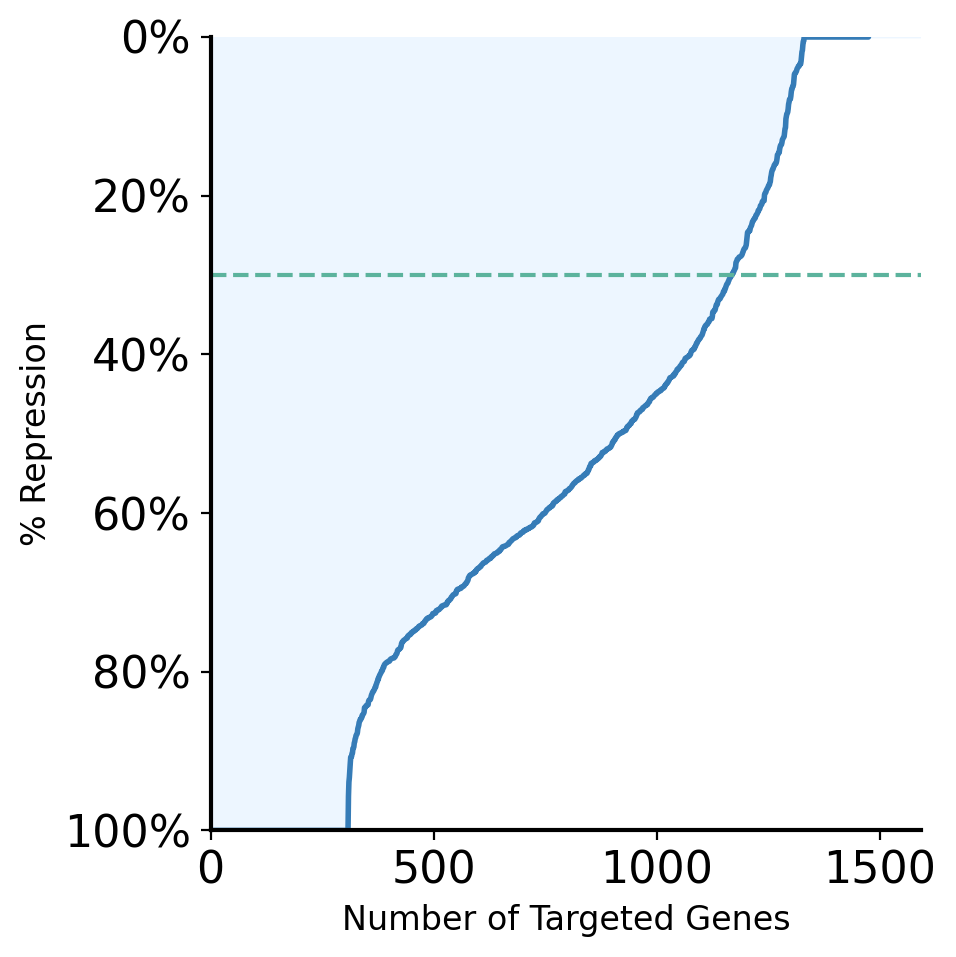

In [15]:
fig2 = psp.pl.plot_percentage_perturbations_by_repression(adata, perturbation_col='gene_target', xlabel='Number of Targeted Genes')

Remove cells that received sgRNA which do not result in >30% on-target knockdown

Processing batch: ALPHA
Removing 1303 guides due to low repression (less than 30.0%)
Removing 11822 cells due to no repression (Target knockdown < 0)
Removing 117 guides due to low cell count per guide (less than 25 cells per guide)


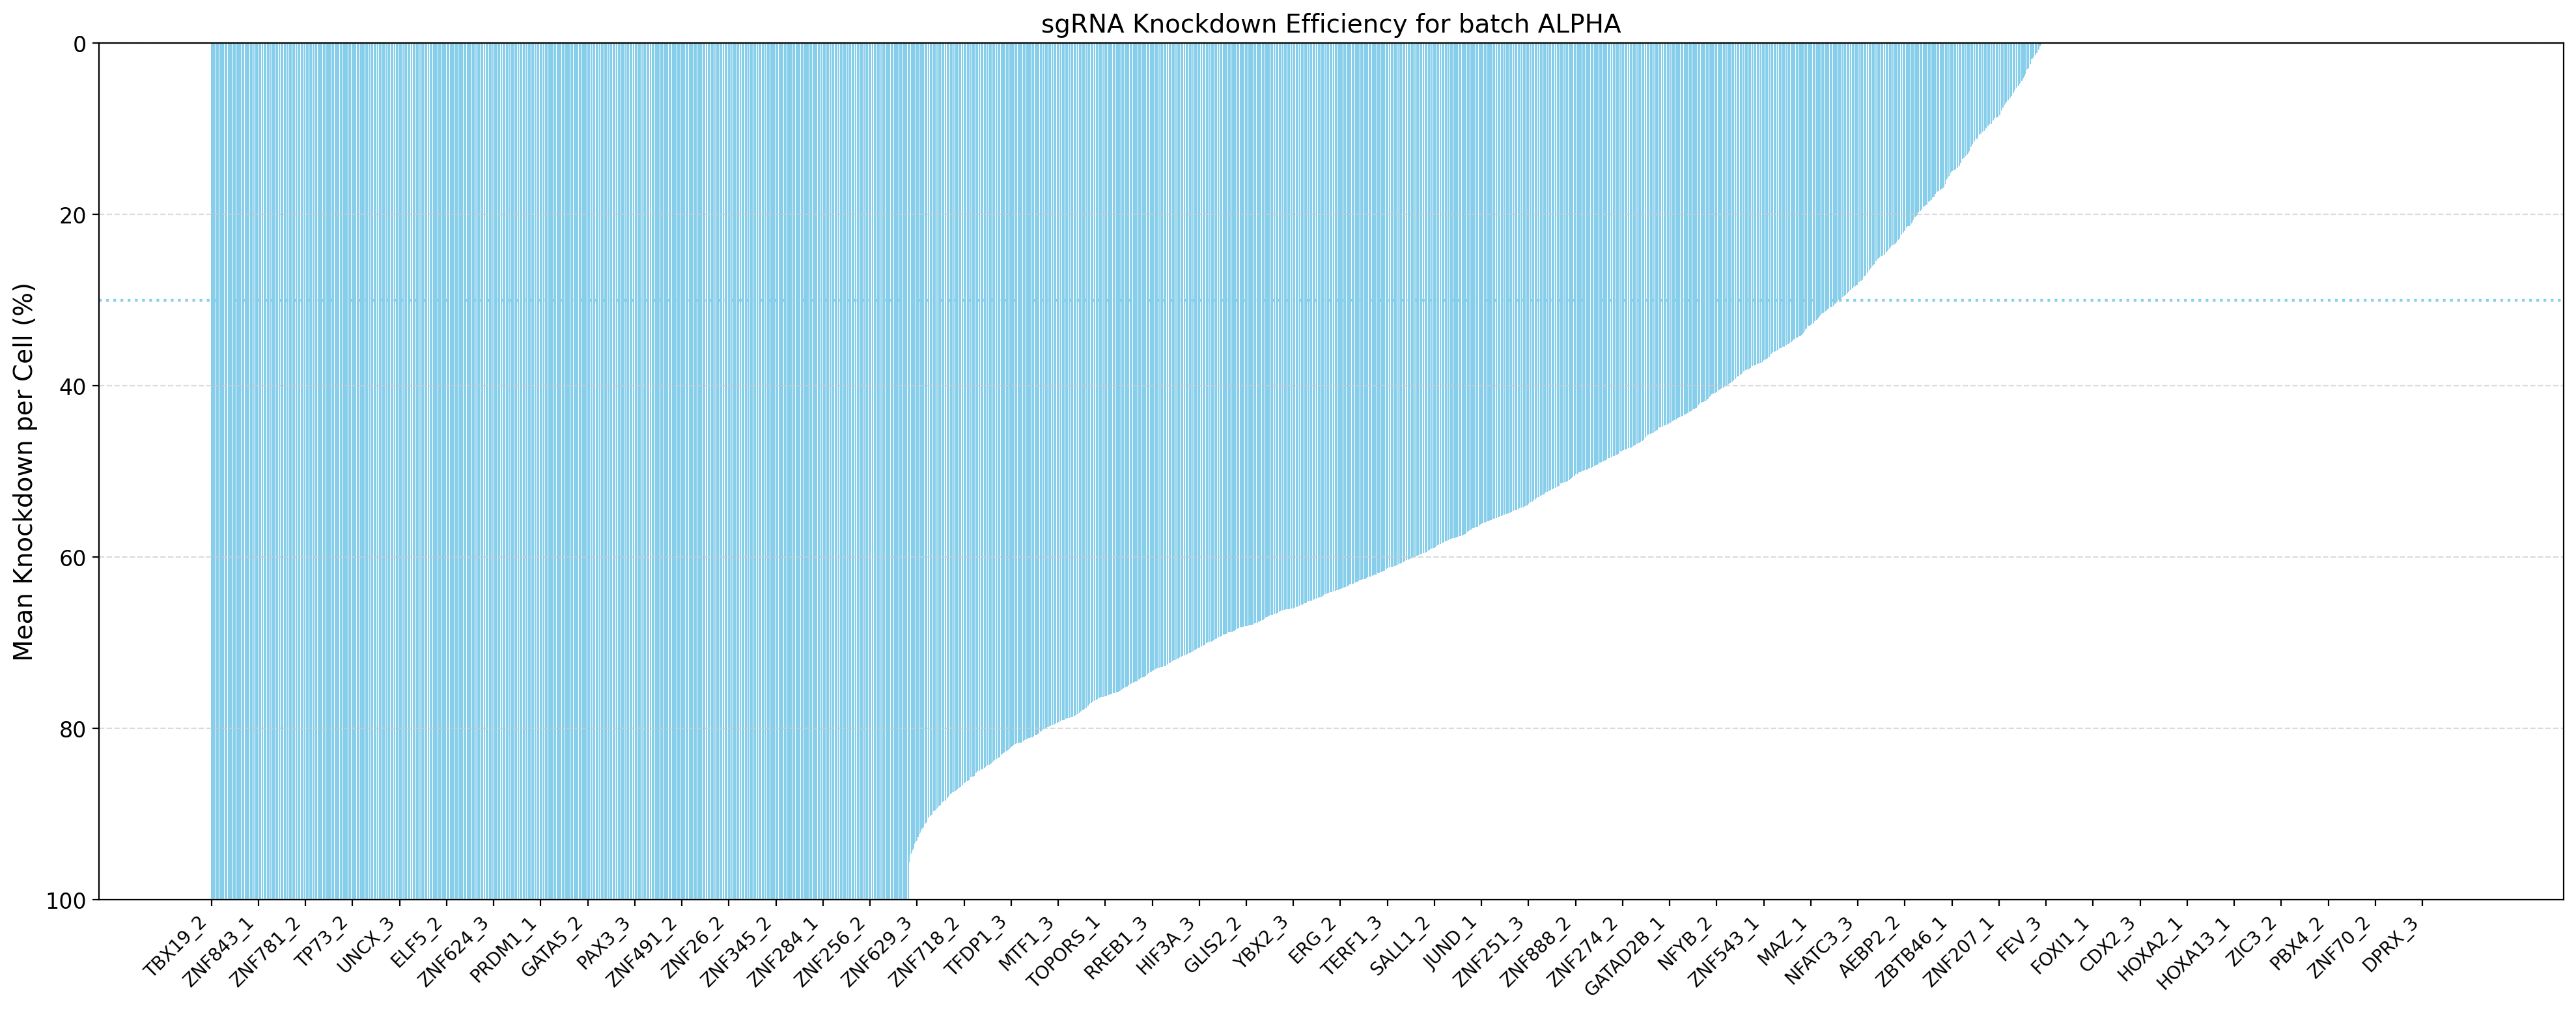

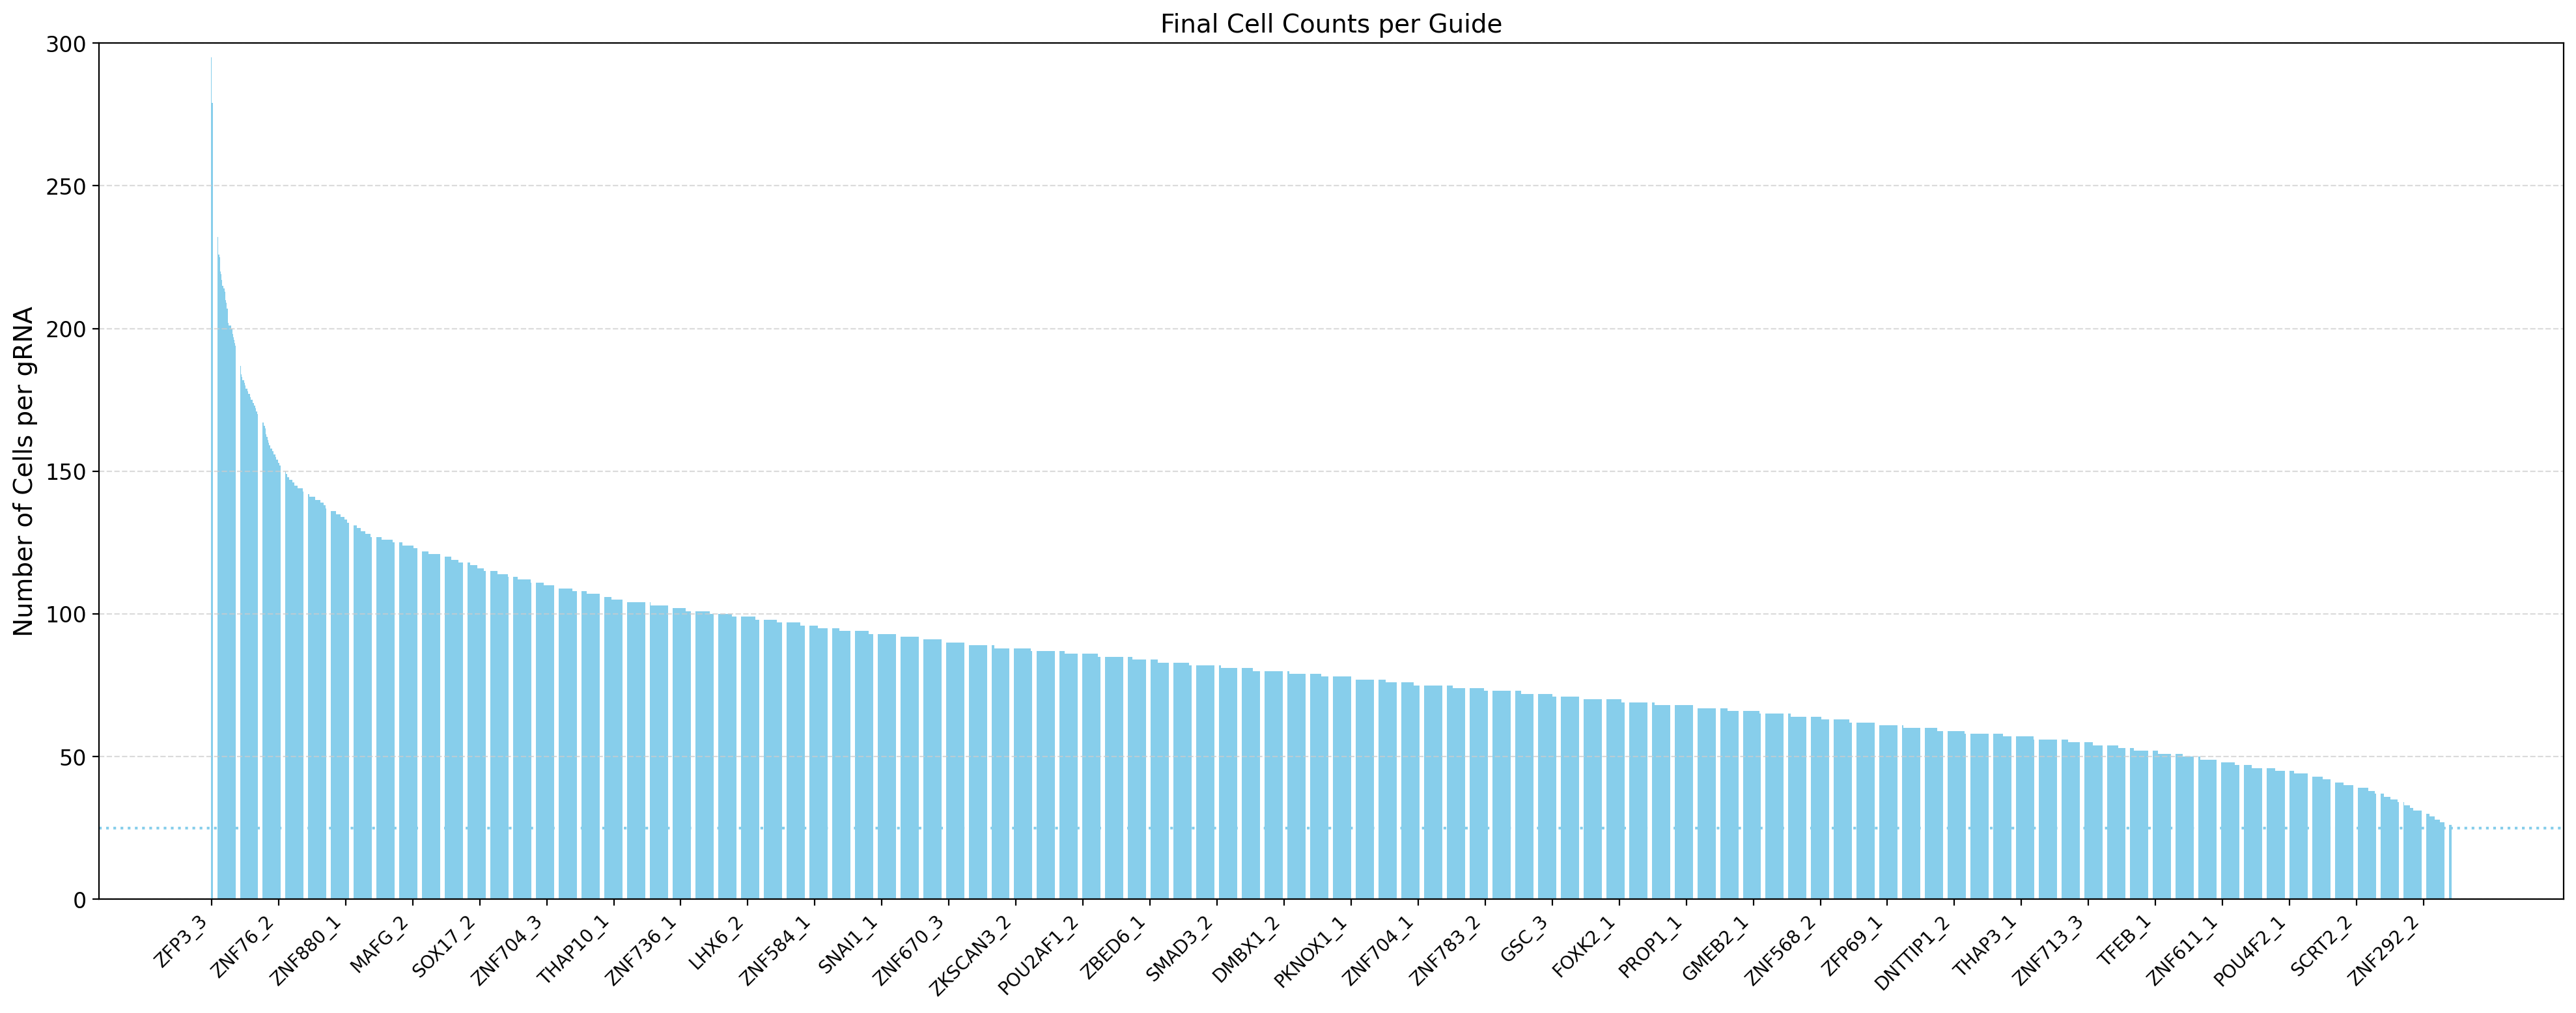

In [16]:
adata = psp.pp.evaluate_per_sgRNA_knockdown(adata)

In [17]:
adata

AnnData object with n_obs × n_vars = 289519 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'batch', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [18]:
adata.write("/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_Knockdown_Filtered.h5ad")

Print statistics

In [19]:
# Final statistics
print(f"Total number of cells: {adata.n_obs}")
print(f"Total number of NTC sgRNAs: {psp.utils.get_ntc_view(adata).obs.gRNA.nunique()}")
print(f"Total number of NTC cells: {psp.utils.get_ntc_view(adata).n_obs}")
print(f"Total number of perturbations: {psp.utils.get_perturbed_view(adata).obs.gRNA.nunique()}")
print(f"Total number of genes targeted: {psp.utils.get_perturbed_view(adata).obs.gene_target.nunique()}")
print(f"Median number of cells per perturbation: {psp.utils.get_perturbed_view(adata).obs.perturbation.value_counts().median()}")
print(f"Median number of cells per gene_target: {psp.utils.get_perturbed_view(adata).obs.gene_target.value_counts().median()}")

Total number of cells: 289519
Total number of NTC sgRNAs: 234
Total number of NTC cells: 13674
Total number of perturbations: 3342
Total number of genes targeted: 1365
Median number of cells per perturbation: 78.0
Median number of cells per gene_target: 202.0


# Filtering sgRNAs by Energy Distance Testing

In [2]:
data_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_Knockdown_Filtered.h5ad"
adata = psp.utils.read_anndata(data_path)

In [3]:
# Delete "batch" from adata.obs so that data is processed as a single batch
del adata.obs["batch"]
adata

AnnData object with n_obs × n_vars = 289519 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [4]:
estats = psp.da.compute_etest(adata, n_jobs=25, seed=123)

Processing entire dataset as a single batch - 289519 cells
filtered out 59 genes that are detected in less than 3 cells
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:01)


/usr/lib64/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.


computing PCA
    with n_comps=50
    finished (0:00:39)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PCs', the loadings (adata.varm)
    'pca_variance', the variance / eigenvalues (adata.uns['pca'])
    'pca_variance_ratio', the variance ratio (adata.uns['pca'])
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:01:00)
    computed connectivities (0:00:03)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:03)
  Processing perturbations 1-500 of 3342


  0%|          | 0/10000 [00:00<?, ?it/s]

  Processing perturbations 501-1000 of 3342


  0%|          | 0/10000 [00:00<?, ?it/s]

  Processing perturbations 1001-1500 of 3342


  0%|          | 0/10000 [00:00<?, ?it/s]

  Processing perturbations 1501-2000 of 3342


  0%|          | 0/10000 [00:00<?, ?it/s]

  Processing perturbations 2001-2500 of 3342


  0%|          | 0/10000 [00:00<?, ?it/s]

  Processing perturbations 2501-3000 of 3342


  0%|          | 0/10000 [00:00<?, ?it/s]

  Processing perturbations 3001-3342 of 3342


  0%|          | 0/10000 [00:00<?, ?it/s]

E-test results stored in AnnData:
  • adata.uns['etest_results'] - Complete results DataFrame
  • adata.obs['perturbation_edist'] - Energy distance for each cell's perturbation
  • adata.obs['perturbation_pvalue'] - P-value for each cell's perturbation (batch-specific)
  • adata.obs['perturbation_significant'] - Whether cell's perturbation is significant (batch-specific)


In [5]:
adata

AnnData object with n_obs × n_vars = 289519 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [6]:
estats.head()

edist  pvalue  significant  pvalue_adj significant_adj  \
DMRT2_1    -0.054357  0.3990        False    0.468148           False   
ARHGAP35_2  0.684763  0.1591        False    0.232388           False   
ESR2_2      2.983441  0.0060         True    0.028562            True   
CENPB_2     1.681764  0.0893        False    0.151146           False   
DUXA_3      6.251532  0.0047         True    0.024275            True   

            neglog10_pvalue_adj batch  
DMRT2_1                0.329617   all  
ARHGAP35_2             0.633786   all  
ESR2_2                 1.544216   all  
CENPB_2                0.820603   all  
DUXA_3                 1.614836   all

In [7]:
estats.to_csv("/home/ranwyl/data_tf_project/etest_results_alpha_CPMnorm.csv")
adata.write("/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_Knockdown_Energy_Test_Computed.h5ad")    

In [8]:
print(f"{len(adata[adata.obs.perturbation_significant == True].obs.gRNA.unique().tolist())}"
    f" gRNAs pass significance threshold")

986 gRNAs pass significance threshold


Restart kernel

In [2]:
import pandas as pd
adata_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_Knockdown_Energy_Test_Computed.h5ad"
adata = psp.utils.read_anndata(adata_filepath)
estats_filepath = "/home/ranwyl/data_tf_project/etest_results_alpha_CPMnorm.csv"
estats = pd.read_csv(estats_filepath, index_col=0)

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10


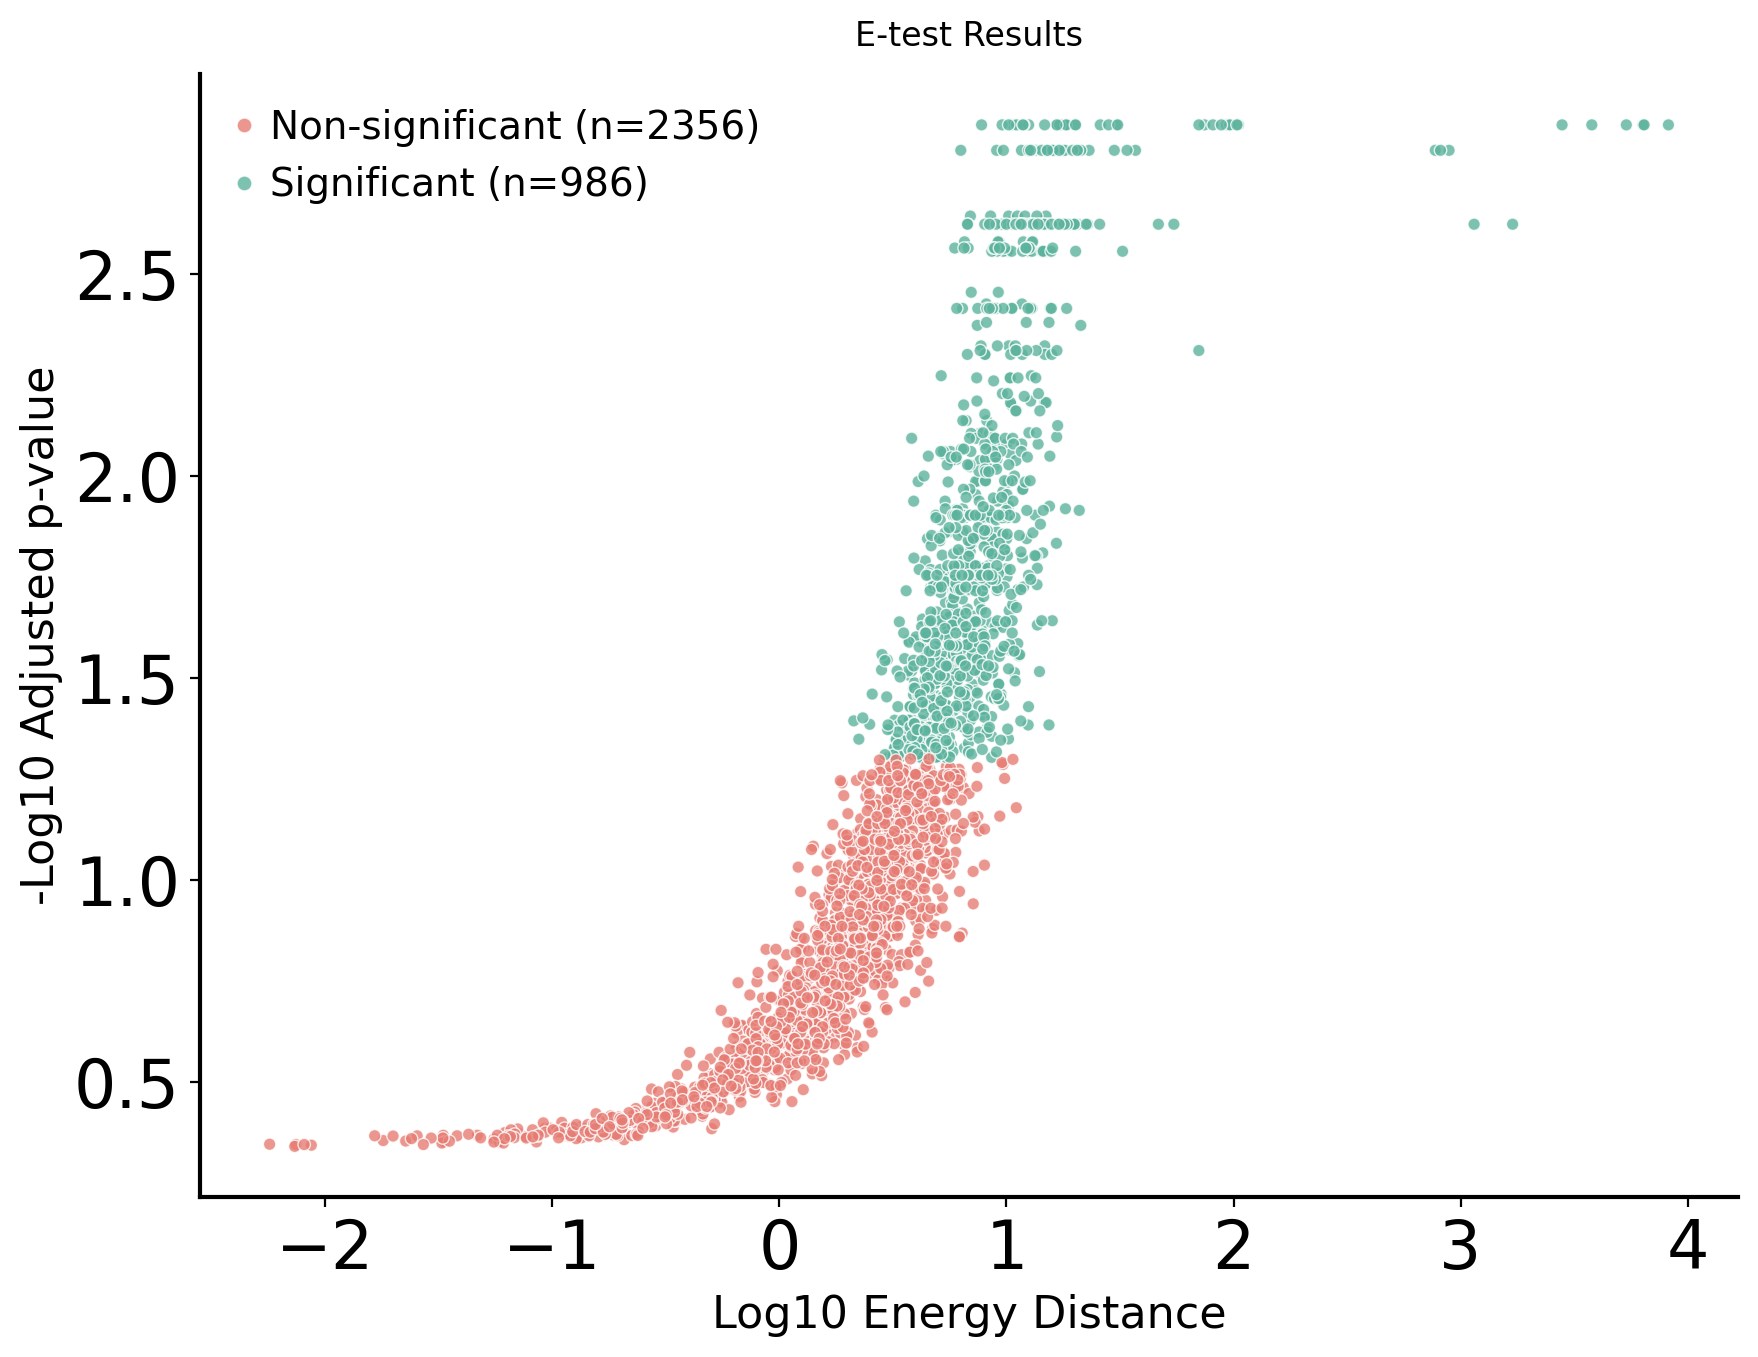

In [3]:
estats['gene'] = estats.index.to_series().str.rsplit('_', n=1).str[0]
fig = psp.pl.plot_etest_results(estats, significance_column="significant_adj",
                                pvalue_column="pvalue_adj",
                                palette={'True': '#5CB39D', 
                                         'False': '#E67C73', 
                                         'NTC': '#367CB7'})


Concordance between max repression and max energy distance:
  • 452/1197 genes (37.8%) have the same sgRNA showing maximum repression and maximum energy distance
  • Average Pearson correlation between repression and energy distance: -0.044
  • Median Pearson correlation: -0.083
  • Found valid correlations for 70/1197 genes


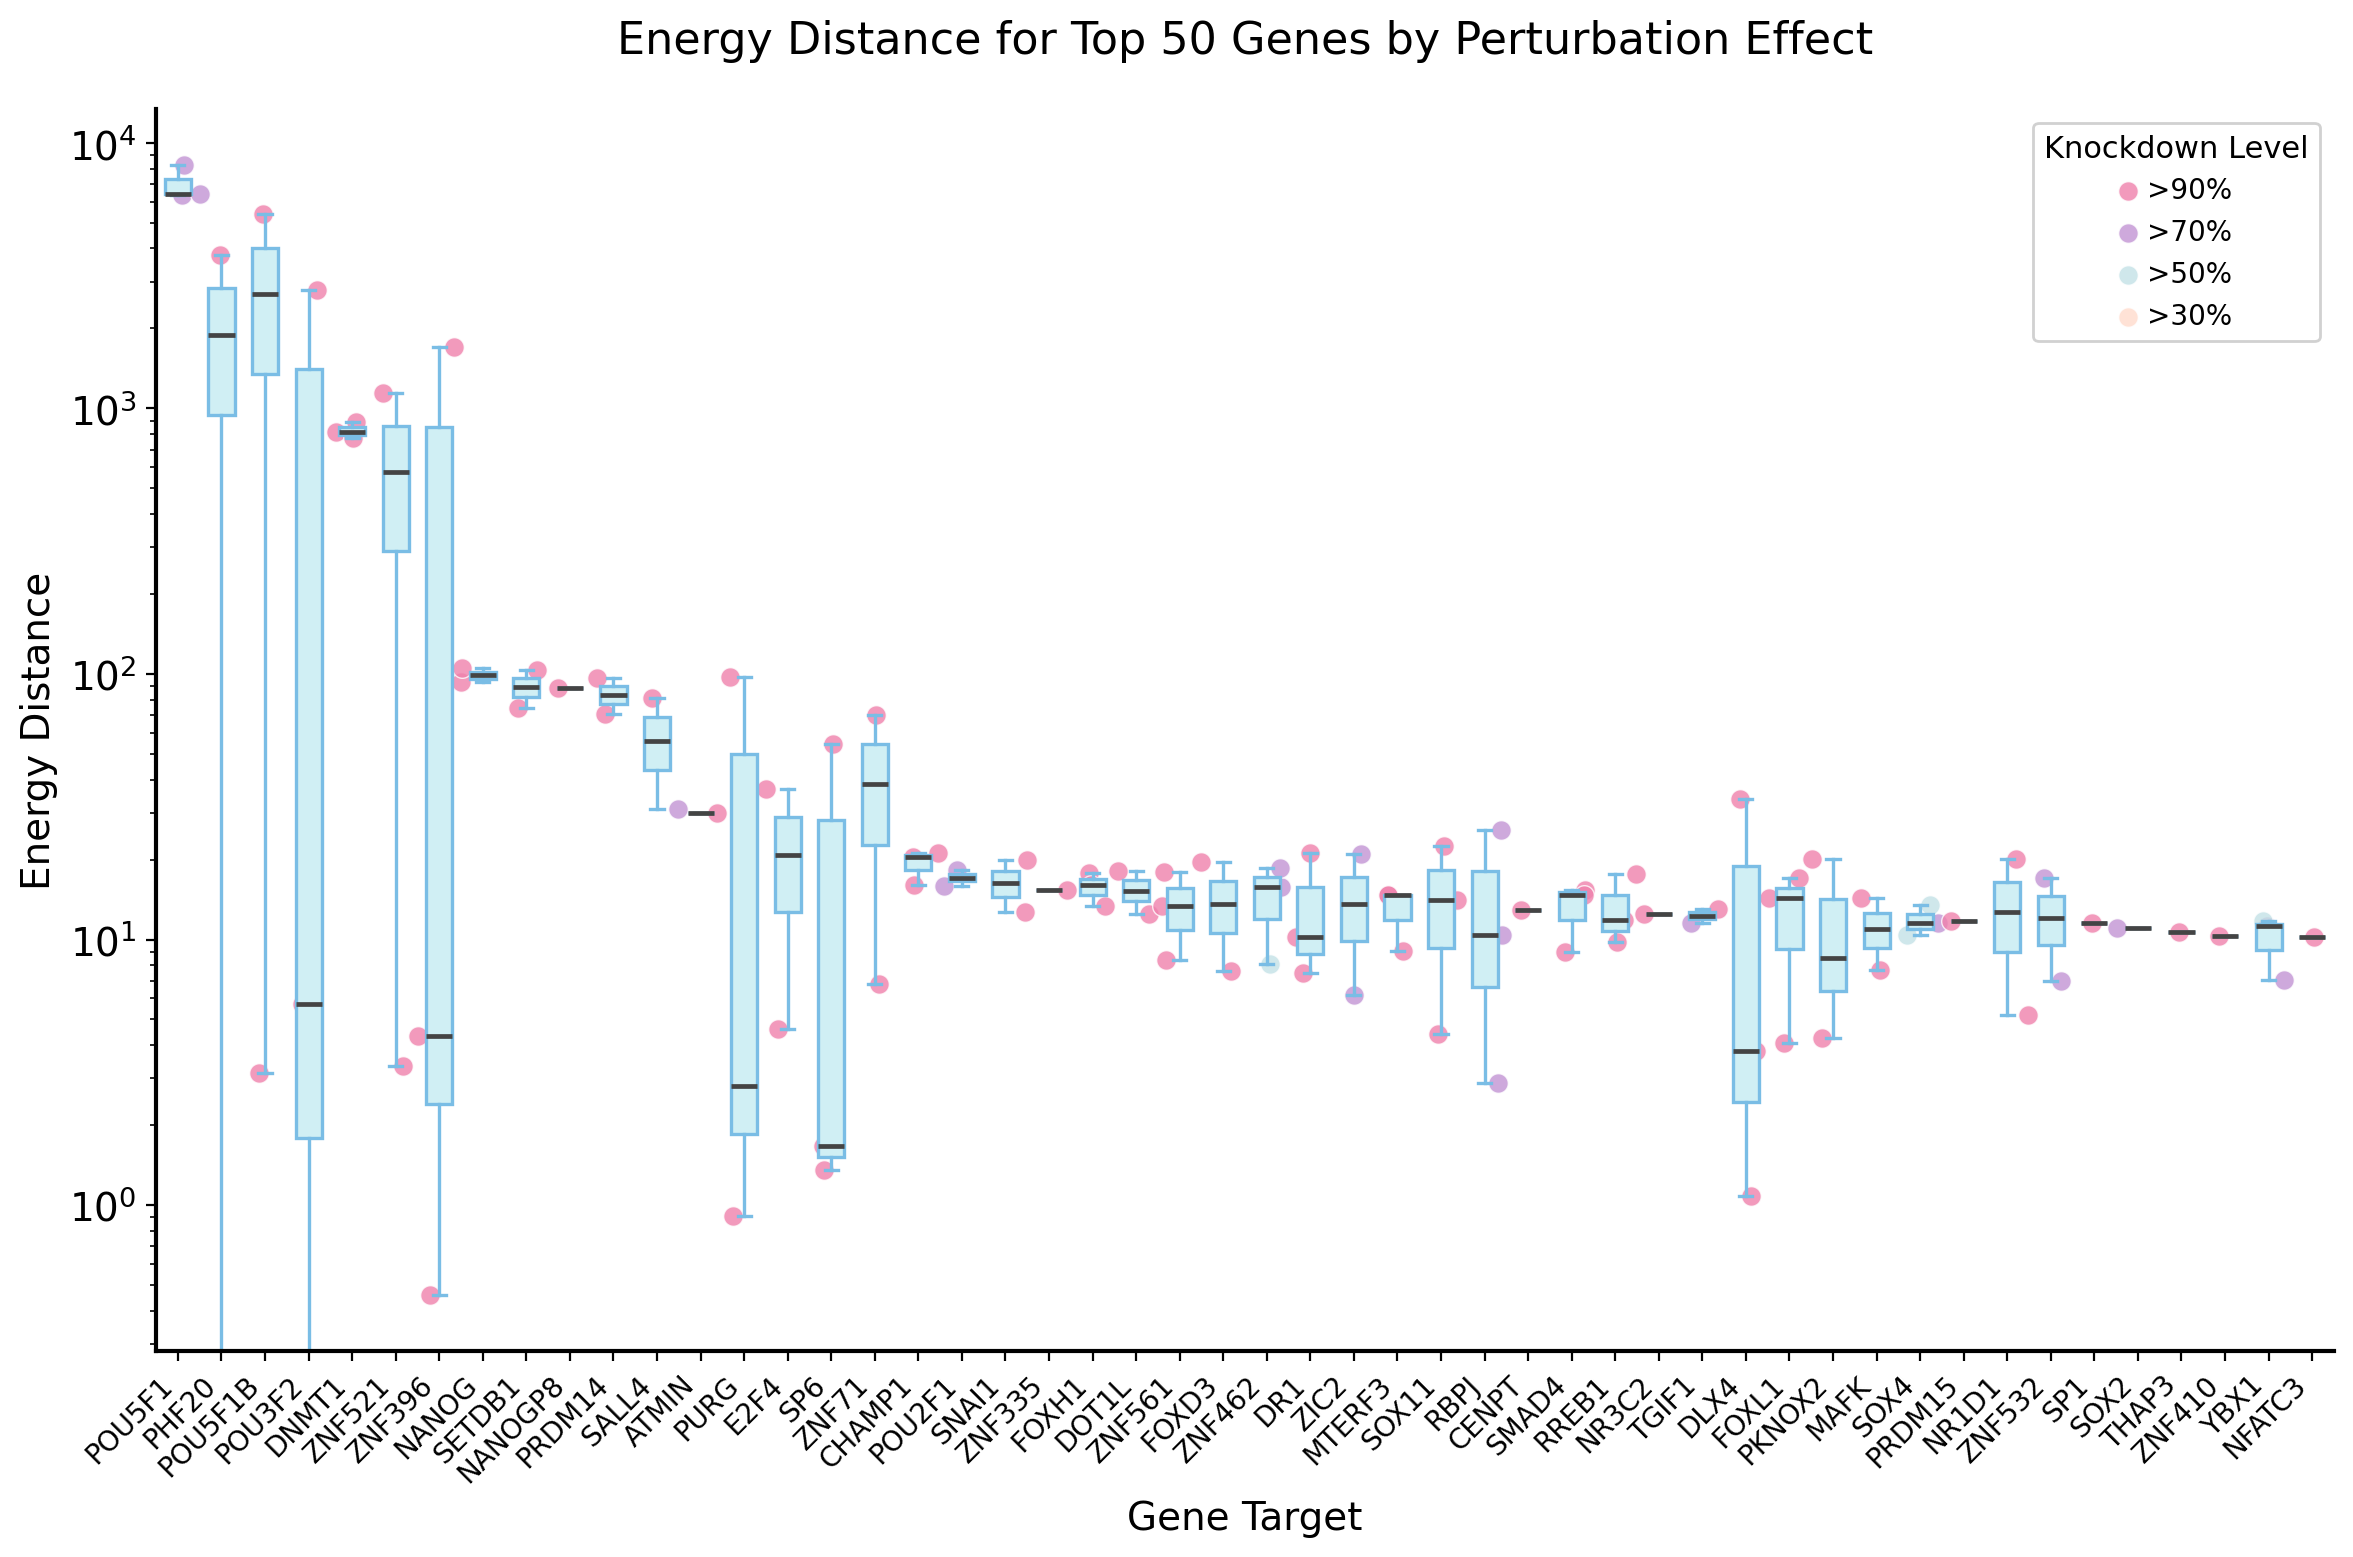

In [4]:
import warnings
# Catch this warning:
# /home/ranwyl/KOLF2.1J_Perturbation_Cell_Atlas/psp/pl/plotting.py:1085: 
#   ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig = psp.pl.plot_energy_distance_vs_knockdown(adata, log_scale=True, n_genes=50)

In [5]:
adata

AnnData object with n_obs × n_vars = 289519 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [6]:
print(adata[adata.obs.perturbation_significant == True].shape[0])
print(adata[adata.obs.perturbed == "False"].shape[0])

88249
13674


In [7]:
adata_filtered = adata[(adata.obs.perturbation_significant == True) | 
                (adata.obs.perturbed == "False")].copy()
adata_filtered

AnnData object with n_obs × n_vars = 101923 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [8]:
adata_filtered.write("/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_Knockdown_Energy_Test_Filtered.h5ad")

In [13]:
adata_filtered

AnnData object with n_obs × n_vars = 101923 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

# Post E-Test Sanity Checks

In [2]:
adata_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_Knockdown_Energy_Test_Filtered.h5ad"
adata_filtered = psp.utils.read_anndata(adata_filepath)

In [3]:
adata_filtered

AnnData object with n_obs × n_vars = 101923 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [5]:
adata_kds = adata_filtered[adata_filtered.obs.perturbed == "True"]
print(adata_kds.shape)

(88249, 20043)


In [6]:
adata_ntc = adata_filtered[adata_filtered.obs.perturbed == "False"]
print(adata_ntc.shape)

(13674, 20043)


In [64]:
print(f"Number of NTC gRNA: {adata_ntc.obs.gRNA.nunique()}")

Number of NTC gRNA: 234


In [4]:
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histogram(adata: ad.AnnData, obs_key: str, title: str="",
                    fig_size: tuple=(4,3), bin_width=25, xtick_width=50):
    plt.figure(figsize=fig_size)
    adata_xmax = max(adata.obs[obs_key].value_counts().values)
    xmax = ((adata_xmax // bin_width) + 1) * bin_width
    sns.histplot(adata.obs[obs_key].value_counts().values, binwidth=bin_width,
        binrange=(0,xmax))
    plt.xlim(0, xmax)
    plt.xticks(np.arange(0, xmax, xtick_width), fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(False)
    plt.title(title)

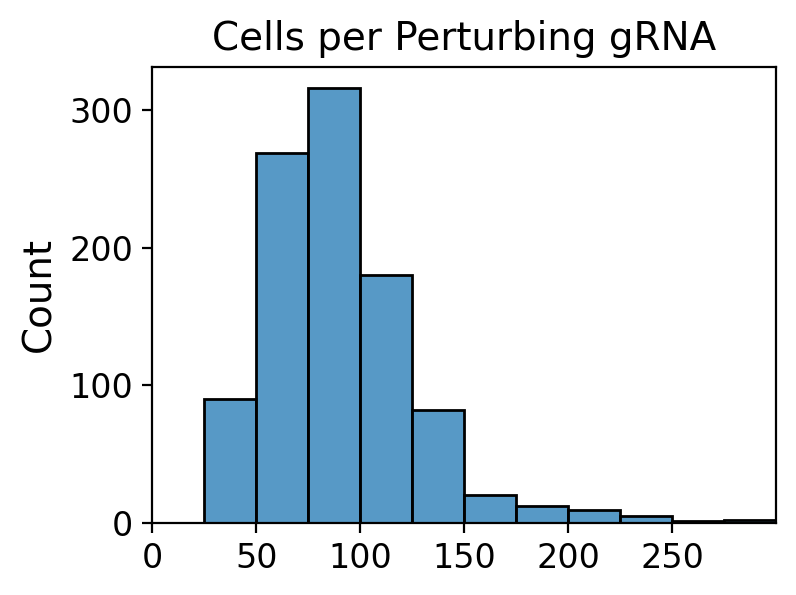

In [33]:
plot_histogram(adata_kds, "gRNA", "Cells per Perturbing gRNA")

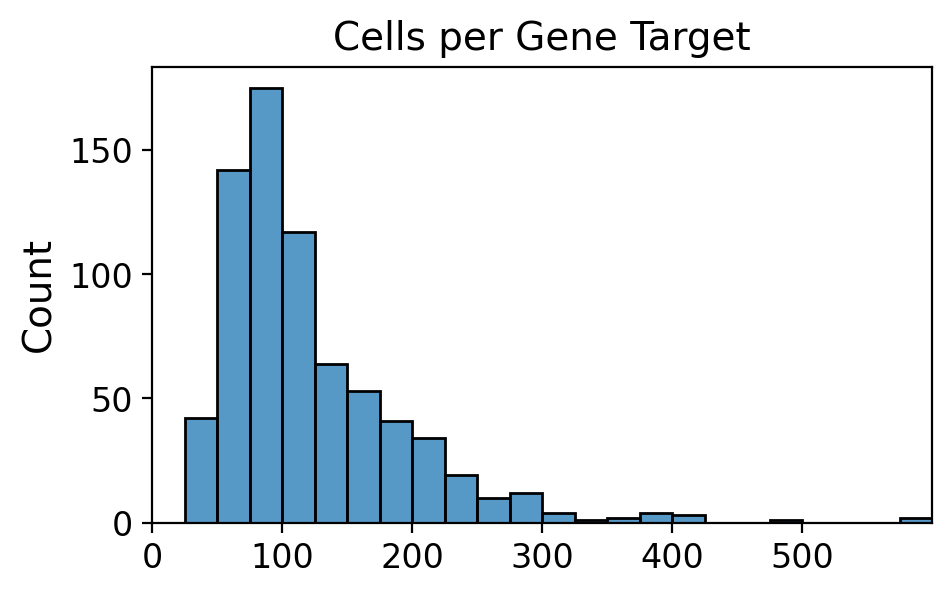

In [39]:
plot_histogram(adata_kds, "gene_target", "Cells per Gene Target", 
               fig_size=(5,3), xtick_width=100)

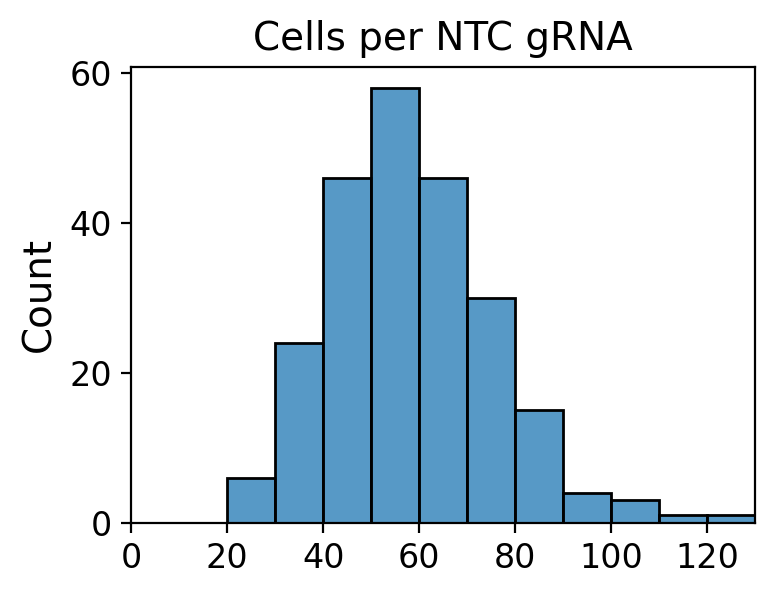

In [38]:
plot_histogram(adata_ntc, "gRNA", "Cells per NTC gRNA", 
    bin_width=10, xtick_width=20)

How many gRNA per gene target?

In [44]:
adata_kds.obs.gRNA.head()

AAACGAAGTCTACACA-1      ESR2_2
AAACGAAGTGGACTAG-1     ZNF14_1
AAACGAAGTGTCTAAC-1      JRKL_2
AAACGCTCAGTTAGGG-1    TWIST1_2
AAAGAACGTAAGATTG-1     GATA6_3
Name: gRNA, dtype: category
Categories (986, object): ['ADNP2_1', 'ADNP2_2', 'ADNP2_3', 'AHR_2', ..., 'ZSCAN23_3', 'ZSCAN30_1', 'ZSCAN32_2', 'ZXDC_3']

In [45]:
adata_kds.obs.gene_target.head()

AAACGAAGTCTACACA-1      ESR2
AAACGAAGTGGACTAG-1     ZNF14
AAACGAAGTGTCTAAC-1      JRKL
AAACGCTCAGTTAGGG-1    TWIST1
AAAGAACGTAAGATTG-1     GATA6
Name: gene_target, dtype: category
Categories (726, object): ['ADNP2', 'AHR', 'ALX4', 'ANKZF1', ..., 'ZSCAN23', 'ZSCAN30', 'ZSCAN32', 'ZXDC']

In [60]:
import pandas as pd

def count_gRNA_per_gene_target(adata, print_results=True):
    gene_target_list = adata.obs.gene_target.unique().tolist()
    gene_target_dict = {gene: 0 for gene in gene_target_list}
    gRNA_list = adata.obs.gRNA.unique().tolist()
    for gRNA in gRNA_list:
        gene_target = gRNA.split("_")[0]
        gene_target_dict[gene_target] += 1
    df = pd.DataFrame.from_dict(gene_target_dict, orient="index",
        columns=["n_gRNA"])
    df.index.name = "gene_target"
    if print_results == True:
        n_gRNA_list = [1, 2, 3]
        for n in n_gRNA_list:
            df_filt = df[df["n_gRNA"] == n]
            print(f"Number of gene targets with {n} gRNA: {df_filt.shape[0]}")
    return df

In [61]:
gRNA_count_df = count_gRNA_per_gene_target(adata_kds)

Number of gene targets with 1 gRNA: 503
Number of gene targets with 2 gRNA: 186
Number of gene targets with 3 gRNA: 37


In [62]:
gRNA_count_df.head()

n_gRNA
gene_target        
ESR2              1
ZNF14             2
JRKL              1
TWIST1            1
GATA6             3

<Axes: ylabel='Count'>

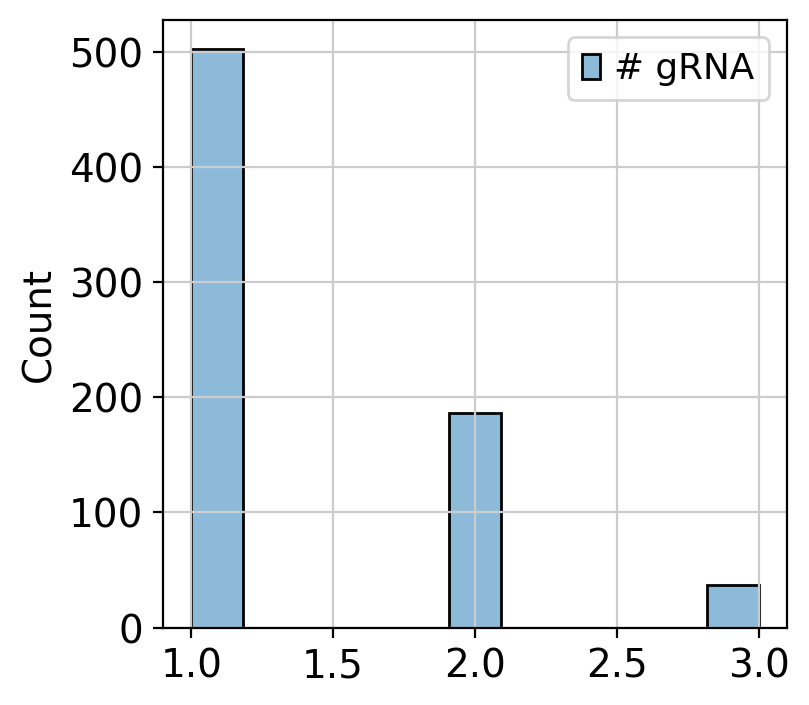

In [56]:
sns.histplot(gRNA_count_df)

Gene filter

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'
import seaborn as sns
import scanpy as sc

def filter_low_expressed_genes(adata, tf_set, percent_threshold=0, min_n_cells=0, silent=False):
    """
    Filter out bottom percentile of genes with lowest expression (counts) 
    and genes expressed in fewer than min_n_cells cells.
    Do not filter out genes that are TFs in tf_set.
    """
    n_genes_before = adata.shape[1]

    # Filter genes expressed in fewer than min_n_cells cells
    if silent == False:
        print(f"Removing non-TF genes expressed in <{min_n_cells} cells")
    # Create data matrix
    if silent == False:
        print("Copying data")
    data_matrix = adata.layers["counts"] if "counts" in adata.layers else adata.X
    data_matrix = data_matrix.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    if silent == False:
        print("Filtering genes")
    # Create mask for TFs
    tf_mask = adata.var_names.isin(tf_set)
    # Calculate number of cells expressing each gene
    gene_detected_counts = (data_matrix > 0).sum(axis=0)
    # Set cell number threshold and filter genes
    genes_pass_cell_thr = gene_detected_counts >= min_n_cells
    genes_to_keep = genes_pass_cell_thr | tf_mask
    adata = adata[:, genes_to_keep]
    print(f"Removed {n_genes_before - adata.n_vars} "
        f"non-TF genes expressed in <{min_n_cells} cells")
    n_genes_after_cell_filt = adata.n_vars
    del data_matrix

    # Filter bottom percentile of genes by expression (counts)
    if silent == False:
        print(f"\nRemoving bottom {percent_threshold}% of genes by expression (CPM)")
    if silent == False:
        print("Copying data")
    adata_norm = adata.copy()
    sc.pp.normalize_total(adata_norm, target_sum=1e6)
    if silent == False:
        print("Copying normalized data")
    data_matrix = adata_norm.X.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    if silent == False:
        print("Filtering genes")
    # Create mask for TFs
    tf_mask = adata.var_names.isin(tf_set)
    # Calculate mean expression of each gene
    mean_expr_per_gene = data_matrix.mean(axis=0)
    # Set percent threshold and filter genes
    threshold = np.percentile(mean_expr_per_gene, percent_threshold)
    genes_pass_pct_thr = mean_expr_per_gene > threshold
    genes_to_keep = genes_pass_pct_thr | tf_mask
    adata = adata[:,genes_to_keep]
    print(f"Removed {n_genes_after_cell_filt - adata.n_vars} non-TF genes "
            f"with lowest {percent_threshold}% expression (CPM)")
    print(f"\nRemoved: {n_genes_before - adata.shape[1]} genes total")
    print(f"Remaining: {adata.n_vars} genes")
    del data_matrix
    del adata_norm
    gc.collect()
    return adata.copy()

def histogram_mean_expression(adata, title="Histogram of Mean Gene Expression", 
                              n_bins=75, ymax=None, show_labels=False):
    plt.rcParams["font.size"] = 14
    # Create data matrix
    adata = adata.copy()
    if "counts" in adata.layers:
        adata.X = adata.layers["counts"].copy()
    # Normalize and log1p
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.log1p(adata)
    # Copy
    data_matrix = adata.X.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        data_matrix = data_matrix.toarray()

    # Plot mean expression
    mean_expr = data_matrix.mean(axis=0)
    plt.figure(figsize=(8,4)) if show_labels else plt.figure(figsize=(6,4))
    ax = sns.histplot(mean_expr, bins=n_bins, kde=False)
    plt.xlabel("Mean expression per gene (CPM, log1p)")
    plt.ylabel("Number of genes")
    plt.title(title, fontsize=15)
    if ymax:
        ax.set_ylim(0, ymax)
    if show_labels:
        ax.bar_label(ax.containers[0], rotation=90, padding=3, fontsize=10)
    plt.tight_layout()
    plt.show()
    del data_matrix
    gc.collect()

def histogram_cells_expressing_gene(adata, title="Histogram of # Cells Expressing a Gene", 
                                    n_bins=75, ymax=None, show_labels=False):
    plt.rcParams["font.size"] = 14
    # Use raw counts
    count_matrix = adata.X if "counts" not in adata.layers else adata.layers["counts"]
    count_matrix = count_matrix.copy()
    # Convert from sparse to dense if necessary
    if hasattr(count_matrix, 'toarray'):
        count_matrix = count_matrix.toarray()
    # Plot number of cells expressing each gene
    gene_detected_counts = (count_matrix > 0).sum(axis=0)
    plt.figure(figsize=(8,4)) if show_labels else plt.figure(figsize=(6,4))
    ax = sns.histplot(gene_detected_counts, bins=n_bins, kde=False)
    plt.xlabel("Number of cells in which gene is expressed")
    plt.ylabel("Number of genes")
    plt.title(title, fontsize=15)
    if ymax:
        ax.set_ylim(0, ymax)
    if show_labels:
        ax.bar_label(ax.containers[0], rotation=90, padding=3, fontsize=10)
    plt.tight_layout()
    plt.show()
    del count_matrix
    gc.collect()

normalizing counts per cell
    finished (0:00:00)


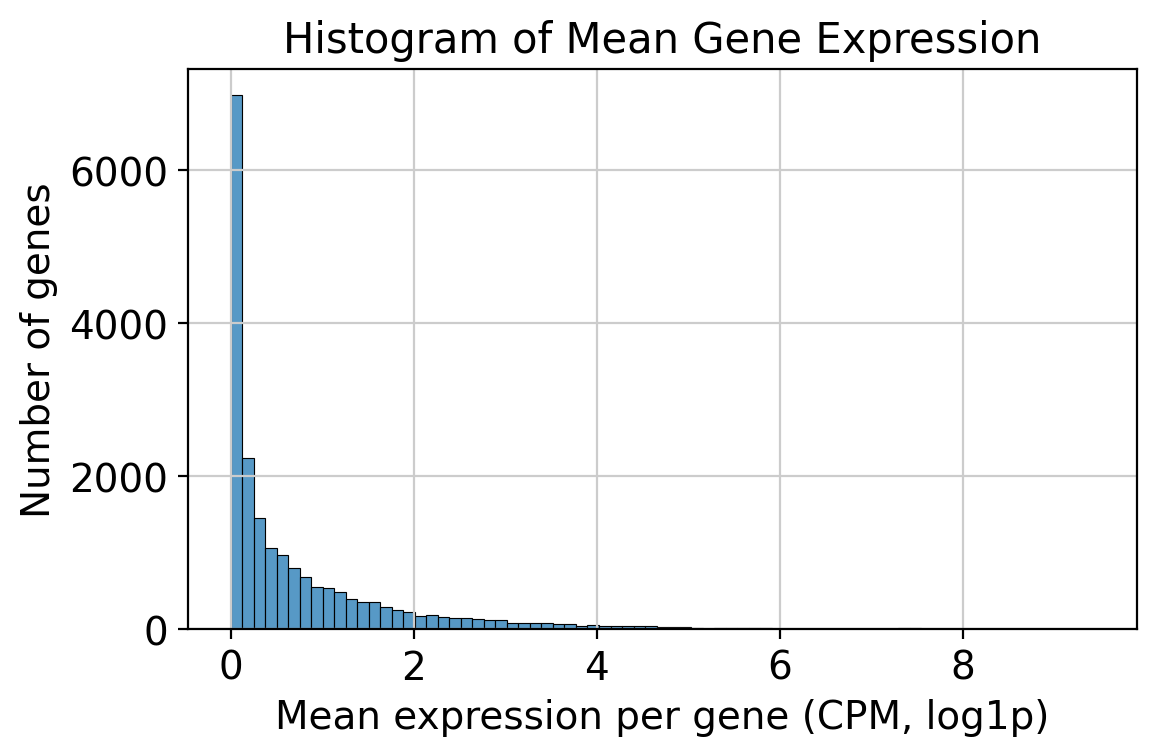

In [ ]:
histogram_mean_expression(adata_filtered)

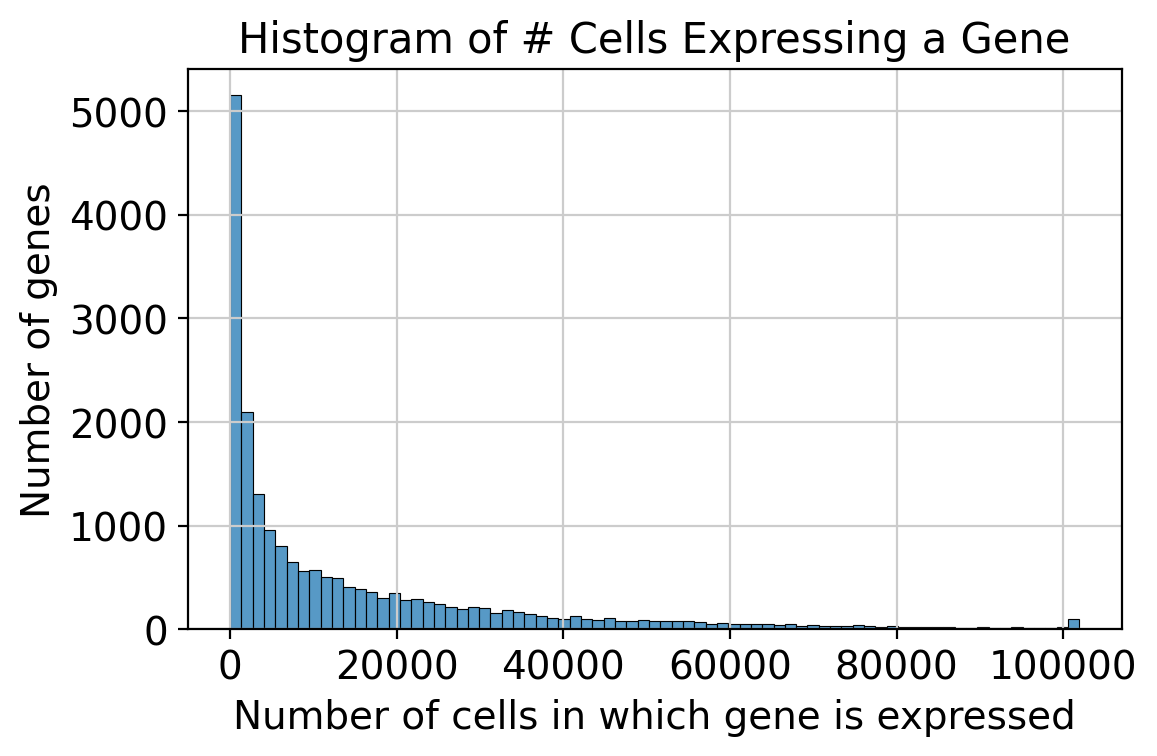

In [12]:
histogram_cells_expressing_gene(adata_filtered)

In [23]:
def plot_KD_efficiency(adata, figsize=(4,3), group_by="gRNA",
                            title="Mean knockdown efficiency"):
    adata_kd = adata[adata.obs.perturbed == "True"]
    if (group_by == "gRNA") or (group_by == "gene_target"):
        kd_efficiency = 100 * adata_kd.obs.groupby(group_by)["target_knockdown"].mean()
    else:
        kd_efficiency = 100 * adata_kd.obs["target_knockdown"]
    plt.figure(figsize=figsize)
    sns.histplot(kd_efficiency, binwidth=10, binrange=(0,100))
    plt.xlim(0, 100)
    plt.xticks(np.arange(0, 100, 10), fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(False)
    plt.title(title)

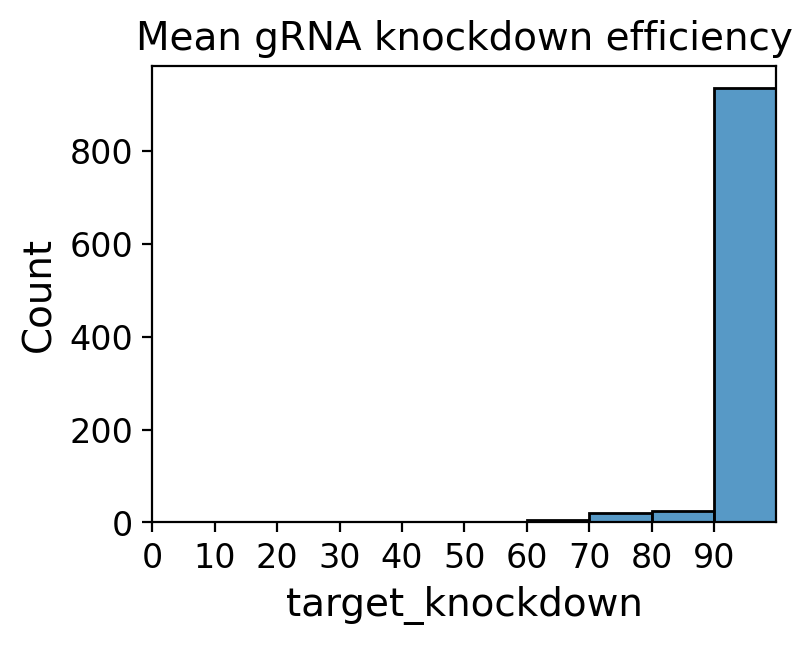

In [19]:
plot_KD_efficiency(adata_filtered, group_by="gRNA", title="Mean gRNA knockdown efficiency")

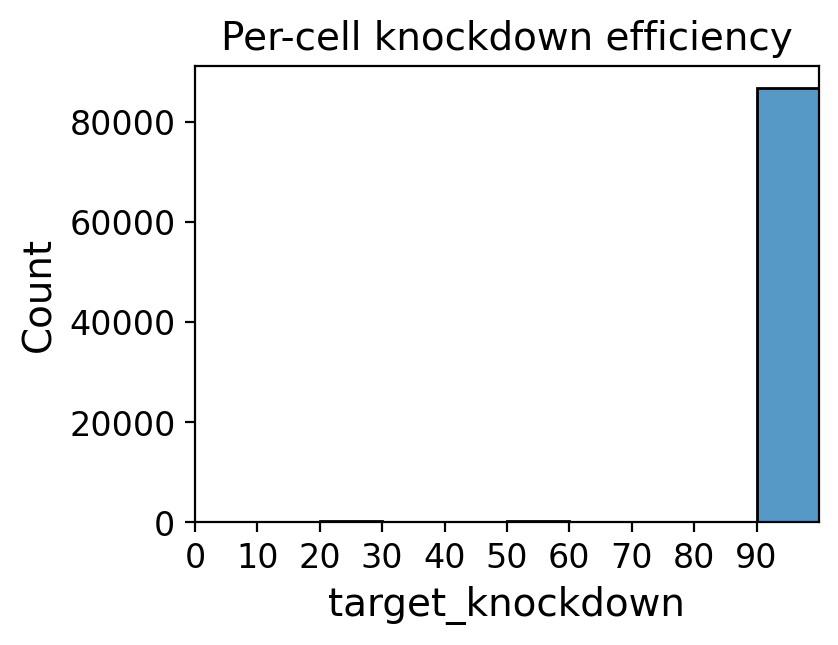

In [24]:
plot_KD_efficiency(adata_filtered, group_by="cell", title="Per-cell knockdown efficiency")

In [41]:
import pandas as pd
import numpy as np

def find_cells_low_knockdown_efficiency(adata, kd_efficiency_pct_threshold=50):
    adata_kd = adata[adata.obs.perturbed == "True"]
    kd_efficiency = 100 * adata_kd.obs["target_knockdown"].values
    kd_efficiency_df = pd.DataFrame(kd_efficiency, columns=["Cell KD efficiency"], 
                                    index=adata_kd.obs.gRNA.values)
    kd_low_efficiency_df = kd_efficiency_df[kd_efficiency_df['Cell KD efficiency'] < kd_efficiency_pct_threshold]
    print(f"{len(kd_low_efficiency_df)} out of {adata.shape[0]} cells "
          f"have <{kd_efficiency_pct_threshold}% KD efficiency")
    print(f"Number of gRNAs with low KD efficiency cells: {kd_low_efficiency_df.index.nunique()}")
    return kd_efficiency_df

In [43]:
kd_cell_efficiency_df = find_cells_low_knockdown_efficiency(adata_filtered, 60)

1082 out of 101923 cells have <60% KD efficiency
Number of gRNAs with low KD efficiency cells: 94
